In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3
%env TF_FORCE_GPU_ALLOW_GROWTH=true

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3
env: TF_FORCE_GPU_ALLOW_GROWTH=true


In [2]:
import os
import pymatgen
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
structures = pd.read_pickle("datasets/structures_defects.pickle.gzip")

In [4]:
target_material = "MoS2"

In [5]:
# TODO(inner perfectionist) eval is unsecure
defects = pd.read_csv(
  "datasets/dichalcogenides_innopolis_202105/descriptors.csv", index_col="_id",
  converters={"cell": eval, "defects": eval})

In [6]:
selected_structures = structures.loc[(defects.loc[structures.descriptor_id].base == target_material).values]

In [7]:
from megnet.models import MEGNetModel
from megnet.data.graph import GaussianDistance
from megnet.data.crystal import CrystalGraph
from megnet.utils.preprocessing import StandardScaler
from megnet.callbacks import ModelCheckpointMAE
from pymatgen.core import Lattice, Structure, Molecule

import tensorflow as tf
import numpy as np

In [8]:
import wandb
from wandb.keras import WandbCallback

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
# TODO(kazeevn) pass structure as the global state
train, test = train_test_split(selected_structures, test_size=0.25, random_state=42)

In [11]:
wandb.init(project='ai4material_design', entity='kazeev')

wandb: Currently logged in as: kazeev (use `wandb login --relogin` to force relogin)


In [12]:
config = wandb.config
config.target = "homo"

In [13]:
from typing import Union, List, Dict
from megnet.data.graph import StructureGraphFixedRadius
from pymatgen.analysis.local_env import NearNeighbors
from megnet.data.graph import Converter
class ZAwareStrucutreGraph(StructureGraphFixedRadius):
    def __init__(
        self,
        nn_strategy: Union[str, NearNeighbors] = "MinimumDistanceNNAll",
        atom_converter: Converter = None,
        bond_converter: Converter = None,
        cutoff: float = 5.0,
    ):
      self.cutoff = cutoff
      super().__init__(
              nn_strategy=nn_strategy, atom_converter=atom_converter, bond_converter=bond_converter, cutoff=self.cutoff
      )
        
      @staticmethod
      def get_atom_features(structure):
        return [[i.species.Z, i.coords[2]] for i in structure.sites]

In [14]:
nfeat_edge = 10
gc = ZAwareStrucutreGraph(bond_converter=GaussianDistance(np.linspace(0, 15, nfeat_edge), 0.5), cutoff=15)
model = MEGNetModel(nfeat_edge=nfeat_edge, nfeat_global=2, graph_converter=gc, npass=2)

In [15]:
scaler = StandardScaler.from_training_data(train.defect_representation,
                                           train[config.target], is_intensive=True)
model.target_scaler = scaler

In [16]:
model.train(train.defect_representation, train[config.target],
            validation_structures=test.defect_representation,
            validation_targets=test[config.target],
            callbacks=[WandbCallback()],
            epochs=10000, verbose=1, patience=1000)

Epoch 1/10000


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning:

Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/set2set_atom/Reshape_9:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/set2set_atom/Reshape_8:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradient_tape/model/set2set_atom/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:437: UserWarning:

Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/set2set_bond/Reshape_9:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/set2set_bond/Reshape_8:0", shape=(None,), dtype=float32), dense_shape=Tensor("gradient_tape/model/set2set_bond/Cast:0", shape=(1,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of m

6/6 [==============================] - 18s 96ms/step - loss: 1.4128


INFO:megnet.callbacks:
Epoch 00001: val_mae improved from inf to 0.06258, saving model to callback/val_mae_00001_0.062582.hdf5


Epoch 2/10000
6/6 [==============================] - 1s 95ms/step - loss: 1.0451


INFO:megnet.callbacks:
Epoch 00002: val_mae improved from 0.06258 to 0.05790, saving model to callback/val_mae_00002_0.057896.hdf5


Epoch 3/10000
6/6 [==============================] - 1s 95ms/step - loss: 1.0221
Epoch 4/10000
6/6 [==============================] - 1s 167ms/step - loss: 1.2510
Epoch 5/10000
6/6 [==============================] - 1s 204ms/step - loss: 1.0754
Epoch 6/10000
6/6 [==============================] - 1s 173ms/step - loss: 0.9972
Epoch 7/10000
6/6 [==============================] - 1s 102ms/step - loss: 1.0644


INFO:megnet.callbacks:
Epoch 00007: val_mae improved from 0.05790 to 0.05773, saving model to callback/val_mae_00007_0.057726.hdf5


Epoch 8/10000
6/6 [==============================] - 1s 186ms/step - loss: 1.0242
Epoch 9/10000
6/6 [==============================] - 1s 176ms/step - loss: 0.9826
Epoch 10/10000
6/6 [==============================] - 1s 89ms/step - loss: 1.0281
Epoch 11/10000
6/6 [==============================] - 1s 92ms/step - loss: 1.0201
Epoch 12/10000
6/6 [==============================] - 1s 94ms/step - loss: 1.1442
Epoch 13/10000
6/6 [==============================] - 1s 82ms/step - loss: 1.0043
Epoch 14/10000
6/6 [==============================] - 1s 83ms/step - loss: 1.0030
Epoch 15/10000
6/6 [==============================] - 1s 88ms/step - loss: 1.0067
Epoch 16/10000
6/6 [==============================] - 1s 98ms/step - loss: 0.8887
Epoch 17/10000
6/6 [==============================] - 1s 92ms/step - loss: 1.0910
Epoch 18/10000
6/6 [==============================] - 1s 95ms/step - loss: 1.0971
Epoch 19/10000
6/6 [==============================] - 1s 106ms/step - loss: 0.8011
Epoch 20/10000


INFO:megnet.callbacks:
Epoch 00020: val_mae improved from 0.05773 to 0.05711, saving model to callback/val_mae_00020_0.057106.hdf5


Epoch 21/10000
6/6 [==============================] - 1s 92ms/step - loss: 0.8844
Epoch 22/10000
6/6 [==============================] - 1s 95ms/step - loss: 1.0437
Epoch 23/10000
6/6 [==============================] - 1s 84ms/step - loss: 0.9155


INFO:megnet.callbacks:
Epoch 00023: val_mae improved from 0.05711 to 0.05672, saving model to callback/val_mae_00023_0.056721.hdf5


Epoch 24/10000
6/6 [==============================] - 1s 88ms/step - loss: 0.9555
Epoch 25/10000
6/6 [==============================] - 1s 85ms/step - loss: 0.9806


INFO:megnet.callbacks:
Epoch 00025: val_mae improved from 0.05672 to 0.05221, saving model to callback/val_mae_00025_0.052213.hdf5


Epoch 26/10000
6/6 [==============================] - 1s 94ms/step - loss: 0.7815


INFO:megnet.callbacks:
Epoch 00026: val_mae improved from 0.05221 to 0.04761, saving model to callback/val_mae_00026_0.047614.hdf5


Epoch 27/10000
6/6 [==============================] - 1s 93ms/step - loss: 0.7704
Epoch 28/10000
6/6 [==============================] - 1s 90ms/step - loss: 0.6771


INFO:megnet.callbacks:
Epoch 00028: val_mae improved from 0.04761 to 0.04724, saving model to callback/val_mae_00028_0.047244.hdf5


Epoch 29/10000
6/6 [==============================] - 1s 84ms/step - loss: 0.6156
Epoch 30/10000
6/6 [==============================] - 1s 103ms/step - loss: 0.7901
Epoch 31/10000
6/6 [==============================] - 1s 88ms/step - loss: 0.7833
Epoch 32/10000
6/6 [==============================] - 1s 90ms/step - loss: 0.7565
Epoch 33/10000
6/6 [==============================] - 1s 95ms/step - loss: 1.2281


INFO:megnet.callbacks:
Epoch 00033: val_mae improved from 0.04724 to 0.04425, saving model to callback/val_mae_00033_0.044246.hdf5


Epoch 34/10000
6/6 [==============================] - 1s 91ms/step - loss: 0.5970


INFO:megnet.callbacks:
Epoch 00034: val_mae improved from 0.04425 to 0.04343, saving model to callback/val_mae_00034_0.043430.hdf5


Epoch 35/10000
6/6 [==============================] - 1s 98ms/step - loss: 0.6377
Epoch 36/10000
6/6 [==============================] - 1s 97ms/step - loss: 0.5658
Epoch 37/10000
6/6 [==============================] - 1s 95ms/step - loss: 0.5059


INFO:megnet.callbacks:
Epoch 00037: val_mae improved from 0.04343 to 0.04320, saving model to callback/val_mae_00037_0.043205.hdf5


Epoch 38/10000
6/6 [==============================] - 1s 91ms/step - loss: 0.5137
Epoch 39/10000
6/6 [==============================] - 1s 87ms/step - loss: 0.6323
Epoch 40/10000
6/6 [==============================] - 1s 88ms/step - loss: 0.4509


INFO:megnet.callbacks:
Epoch 00040: val_mae improved from 0.04320 to 0.04164, saving model to callback/val_mae_00040_0.041644.hdf5


Epoch 41/10000
6/6 [==============================] - 1s 93ms/step - loss: 0.4292


INFO:megnet.callbacks:
Epoch 00041: val_mae improved from 0.04164 to 0.03995, saving model to callback/val_mae_00041_0.039951.hdf5


Epoch 42/10000
6/6 [==============================] - 1s 93ms/step - loss: 0.4157
Epoch 43/10000
6/6 [==============================] - 1s 84ms/step - loss: 0.4903


INFO:megnet.callbacks:
Epoch 00043: val_mae improved from 0.03995 to 0.03983, saving model to callback/val_mae_00043_0.039834.hdf5


Epoch 44/10000
6/6 [==============================] - 1s 98ms/step - loss: 0.4174
Epoch 45/10000
6/6 [==============================] - 1s 100ms/step - loss: 0.5639


INFO:megnet.callbacks:
Epoch 00045: val_mae improved from 0.03983 to 0.03858, saving model to callback/val_mae_00045_0.038578.hdf5


Epoch 46/10000
6/6 [==============================] - 1s 95ms/step - loss: 0.4786
Epoch 47/10000
6/6 [==============================] - 1s 95ms/step - loss: 0.5287
Epoch 48/10000
6/6 [==============================] - 1s 100ms/step - loss: 0.4723
Epoch 49/10000
6/6 [==============================] - 1s 101ms/step - loss: 0.5251


INFO:megnet.callbacks:
Epoch 00049: val_mae improved from 0.03858 to 0.03665, saving model to callback/val_mae_00049_0.036649.hdf5


Epoch 50/10000
6/6 [==============================] - 1s 97ms/step - loss: 0.5196
Epoch 51/10000
6/6 [==============================] - 1s 90ms/step - loss: 0.5572
Epoch 52/10000
6/6 [==============================] - 1s 97ms/step - loss: 0.4238
Epoch 53/10000
6/6 [==============================] - 1s 106ms/step - loss: 0.4567
Epoch 54/10000
6/6 [==============================] - 1s 93ms/step - loss: 0.5310
Epoch 55/10000
6/6 [==============================] - 1s 95ms/step - loss: 0.4243
Epoch 56/10000
6/6 [==============================] - 1s 91ms/step - loss: 0.4826


INFO:megnet.callbacks:
Epoch 00056: val_mae improved from 0.03665 to 0.03650, saving model to callback/val_mae_00056_0.036500.hdf5


Epoch 57/10000
6/6 [==============================] - 1s 88ms/step - loss: 0.4334
Epoch 58/10000
6/6 [==============================] - 1s 82ms/step - loss: 0.4456
Epoch 59/10000
6/6 [==============================] - 1s 85ms/step - loss: 0.4419
Epoch 60/10000
6/6 [==============================] - 1s 88ms/step - loss: 0.4217


INFO:megnet.callbacks:
Epoch 00060: val_mae improved from 0.03650 to 0.03629, saving model to callback/val_mae_00060_0.036294.hdf5


Epoch 61/10000
6/6 [==============================] - 1s 88ms/step - loss: 0.3974


INFO:megnet.callbacks:
Epoch 00061: val_mae improved from 0.03629 to 0.03527, saving model to callback/val_mae_00061_0.035269.hdf5


Epoch 62/10000
6/6 [==============================] - 1s 93ms/step - loss: 0.4707
Epoch 63/10000
6/6 [==============================] - 1s 85ms/step - loss: 0.4369
Epoch 64/10000
6/6 [==============================] - 1s 97ms/step - loss: 0.4580
Epoch 65/10000
6/6 [==============================] - 1s 90ms/step - loss: 0.4190
Epoch 66/10000
6/6 [==============================] - 1s 91ms/step - loss: 0.4265
Epoch 67/10000
6/6 [==============================] - 1s 94ms/step - loss: 0.4496
Epoch 68/10000
6/6 [==============================] - 1s 100ms/step - loss: 0.4212
Epoch 69/10000
6/6 [==============================] - 1s 96ms/step - loss: 0.3933


INFO:megnet.callbacks:
Epoch 00069: val_mae improved from 0.03527 to 0.03487, saving model to callback/val_mae_00069_0.034873.hdf5


Epoch 70/10000
6/6 [==============================] - 1s 91ms/step - loss: 0.5261
Epoch 71/10000
6/6 [==============================] - 1s 103ms/step - loss: 0.4649
Epoch 72/10000
6/6 [==============================] - 1s 100ms/step - loss: 0.4494
Epoch 73/10000
6/6 [==============================] - 1s 120ms/step - loss: 0.3741
Epoch 74/10000
6/6 [==============================] - 1s 90ms/step - loss: 0.4510


INFO:megnet.callbacks:
Epoch 00074: val_mae improved from 0.03487 to 0.03428, saving model to callback/val_mae_00074_0.034279.hdf5


Epoch 75/10000
6/6 [==============================] - 1s 94ms/step - loss: 0.3710
Epoch 76/10000
6/6 [==============================] - 1s 89ms/step - loss: 0.4788
Epoch 77/10000
6/6 [==============================] - 1s 95ms/step - loss: 0.7133
Epoch 78/10000
6/6 [==============================] - 1s 94ms/step - loss: 0.5150
Epoch 79/10000
6/6 [==============================] - 1s 92ms/step - loss: 0.5218
Epoch 80/10000
6/6 [==============================] - 1s 98ms/step - loss: 0.6402
Epoch 81/10000
6/6 [==============================] - 1s 87ms/step - loss: 0.4957
Epoch 82/10000
6/6 [==============================] - 1s 87ms/step - loss: 0.9255
Epoch 83/10000
6/6 [==============================] - 1s 91ms/step - loss: 0.9789
Epoch 84/10000
6/6 [==============================] - 1s 85ms/step - loss: 0.8772
Epoch 85/10000
6/6 [==============================] - 1s 90ms/step - loss: 0.8100
Epoch 86/10000
6/6 [==============================] - 1s 99ms/step - loss: 0.9690
Epoch 87/10000
6

INFO:megnet.callbacks:
Epoch 00121: val_mae improved from 0.03428 to 0.03419, saving model to callback/val_mae_00121_0.034193.hdf5


Epoch 122/10000
6/6 [==============================] - 1s 90ms/step - loss: 0.3418


INFO:megnet.callbacks:
Epoch 00122: val_mae improved from 0.03419 to 0.03397, saving model to callback/val_mae_00122_0.033966.hdf5


Epoch 123/10000
6/6 [==============================] - 1s 102ms/step - loss: 0.3745


INFO:megnet.callbacks:
Epoch 00123: val_mae improved from 0.03397 to 0.03255, saving model to callback/val_mae_00123_0.032553.hdf5


Epoch 124/10000
6/6 [==============================] - 1s 87ms/step - loss: 0.3607
Epoch 125/10000
6/6 [==============================] - 1s 89ms/step - loss: 0.3804
Epoch 126/10000
6/6 [==============================] - 1s 92ms/step - loss: 0.3364
Epoch 127/10000
6/6 [==============================] - 1s 89ms/step - loss: 0.4360


INFO:megnet.callbacks:
Epoch 00127: val_mae improved from 0.03255 to 0.03087, saving model to callback/val_mae_00127_0.030866.hdf5


Epoch 128/10000
6/6 [==============================] - 1s 96ms/step - loss: 0.3514
Epoch 129/10000
6/6 [==============================] - 1s 98ms/step - loss: 0.3254
Epoch 130/10000
6/6 [==============================] - 1s 99ms/step - loss: 0.3104
Epoch 131/10000
6/6 [==============================] - 1s 97ms/step - loss: 0.3662


INFO:megnet.callbacks:
Epoch 00131: val_mae improved from 0.03087 to 0.03075, saving model to callback/val_mae_00131_0.030749.hdf5


Epoch 132/10000
6/6 [==============================] - 1s 99ms/step - loss: 0.3234
Epoch 133/10000
6/6 [==============================] - 1s 89ms/step - loss: 0.3456
Epoch 134/10000
6/6 [==============================] - 1s 85ms/step - loss: 0.3174
Epoch 135/10000
6/6 [==============================] - 1s 94ms/step - loss: 0.3412


INFO:megnet.callbacks:
Epoch 00135: val_mae improved from 0.03075 to 0.03032, saving model to callback/val_mae_00135_0.030315.hdf5


Epoch 136/10000
6/6 [==============================] - 1s 89ms/step - loss: 0.3165
Epoch 137/10000
6/6 [==============================] - 1s 103ms/step - loss: 0.2525


INFO:megnet.callbacks:
Epoch 00137: val_mae improved from 0.03032 to 0.02907, saving model to callback/val_mae_00137_0.029073.hdf5


Epoch 138/10000
6/6 [==============================] - 1s 96ms/step - loss: 0.3041


INFO:megnet.callbacks:
Epoch 00138: val_mae improved from 0.02907 to 0.02895, saving model to callback/val_mae_00138_0.028953.hdf5


Epoch 139/10000
6/6 [==============================] - 1s 88ms/step - loss: 0.3083


INFO:megnet.callbacks:
Epoch 00139: val_mae improved from 0.02895 to 0.02798, saving model to callback/val_mae_00139_0.027981.hdf5


Epoch 140/10000
6/6 [==============================] - 1s 92ms/step - loss: 0.2508
Epoch 141/10000
6/6 [==============================] - 1s 89ms/step - loss: 0.2767
Epoch 142/10000
6/6 [==============================] - 1s 96ms/step - loss: 0.2731
Epoch 143/10000
6/6 [==============================] - 1s 87ms/step - loss: 0.2972
Epoch 144/10000
6/6 [==============================] - 1s 90ms/step - loss: 0.3095
Epoch 145/10000
6/6 [==============================] - 1s 85ms/step - loss: 0.3290
Epoch 146/10000
6/6 [==============================] - 1s 102ms/step - loss: 0.2705
Epoch 147/10000
6/6 [==============================] - 1s 101ms/step - loss: 0.2844
Epoch 148/10000
6/6 [==============================] - 1s 85ms/step - loss: 0.3219
Epoch 149/10000
6/6 [==============================] - 1s 88ms/step - loss: 0.2856


INFO:megnet.callbacks:
Epoch 00149: val_mae improved from 0.02798 to 0.02718, saving model to callback/val_mae_00149_0.027177.hdf5


Epoch 150/10000
6/6 [==============================] - 1s 92ms/step - loss: 0.2862
Epoch 151/10000
6/6 [==============================] - 1s 101ms/step - loss: 0.2944


INFO:megnet.callbacks:
Epoch 00151: val_mae improved from 0.02718 to 0.02697, saving model to callback/val_mae_00151_0.026971.hdf5


Epoch 152/10000
6/6 [==============================] - 1s 93ms/step - loss: 0.2558
Epoch 153/10000
6/6 [==============================] - 1s 90ms/step - loss: 0.2565
Epoch 154/10000
6/6 [==============================] - 1s 101ms/step - loss: 0.2710
Epoch 155/10000
6/6 [==============================] - 1s 84ms/step - loss: 0.2974
Epoch 156/10000
6/6 [==============================] - 1s 90ms/step - loss: 0.2246
Epoch 157/10000
6/6 [==============================] - 1s 85ms/step - loss: 0.2478


INFO:megnet.callbacks:
Epoch 00157: val_mae improved from 0.02697 to 0.02639, saving model to callback/val_mae_00157_0.026387.hdf5


Epoch 158/10000
6/6 [==============================] - 1s 89ms/step - loss: 0.2442
Epoch 159/10000
6/6 [==============================] - 1s 91ms/step - loss: 0.3053
Epoch 160/10000
6/6 [==============================] - 1s 95ms/step - loss: 0.2538
Epoch 161/10000
6/6 [==============================] - 1s 99ms/step - loss: 0.2798
Epoch 162/10000
6/6 [==============================] - 1s 82ms/step - loss: 0.2642


INFO:megnet.callbacks:
Epoch 00162: val_mae improved from 0.02639 to 0.02608, saving model to callback/val_mae_00162_0.026078.hdf5


Epoch 163/10000
6/6 [==============================] - 1s 83ms/step - loss: 0.2326


INFO:megnet.callbacks:
Epoch 00163: val_mae improved from 0.02608 to 0.02566, saving model to callback/val_mae_00163_0.025657.hdf5


Epoch 164/10000
6/6 [==============================] - 1s 96ms/step - loss: 0.2552
Epoch 165/10000
6/6 [==============================] - 1s 101ms/step - loss: 0.2101
Epoch 166/10000
6/6 [==============================] - 1s 87ms/step - loss: 0.2243
Epoch 167/10000
6/6 [==============================] - 1s 91ms/step - loss: 0.2489
Epoch 168/10000
6/6 [==============================] - 1s 93ms/step - loss: 0.2988


INFO:megnet.callbacks:
Epoch 00168: val_mae improved from 0.02566 to 0.02534, saving model to callback/val_mae_00168_0.025341.hdf5


Epoch 169/10000
6/6 [==============================] - 1s 89ms/step - loss: 0.2059


INFO:megnet.callbacks:
Epoch 00169: val_mae improved from 0.02534 to 0.02532, saving model to callback/val_mae_00169_0.025325.hdf5


Epoch 170/10000
6/6 [==============================] - 1s 100ms/step - loss: 0.1742
Epoch 171/10000
6/6 [==============================] - 1s 108ms/step - loss: 0.1975
Epoch 172/10000
6/6 [==============================] - 1s 91ms/step - loss: 0.2370
Epoch 173/10000
6/6 [==============================] - 1s 93ms/step - loss: 0.2718
Epoch 174/10000
6/6 [==============================] - 1s 94ms/step - loss: 0.2607
Epoch 175/10000
6/6 [==============================] - 1s 98ms/step - loss: 0.2687
Epoch 176/10000
6/6 [==============================] - 1s 93ms/step - loss: 0.2506


INFO:megnet.callbacks:
Epoch 00176: val_mae improved from 0.02532 to 0.02502, saving model to callback/val_mae_00176_0.025021.hdf5


Epoch 177/10000
6/6 [==============================] - 1s 89ms/step - loss: 0.2149
Epoch 178/10000
6/6 [==============================] - 1s 87ms/step - loss: 0.2401
Epoch 179/10000
6/6 [==============================] - 1s 89ms/step - loss: 0.2190
Epoch 180/10000
6/6 [==============================] - 1s 94ms/step - loss: 0.2054


INFO:megnet.callbacks:
Epoch 00180: val_mae improved from 0.02502 to 0.02478, saving model to callback/val_mae_00180_0.024778.hdf5


Epoch 181/10000
6/6 [==============================] - 1s 85ms/step - loss: 0.2011
Epoch 182/10000
6/6 [==============================] - 1s 96ms/step - loss: 0.2413
Epoch 183/10000
6/6 [==============================] - 1s 92ms/step - loss: 0.2312


INFO:megnet.callbacks:
Epoch 00183: val_mae improved from 0.02478 to 0.02437, saving model to callback/val_mae_00183_0.024366.hdf5


Epoch 184/10000
6/6 [==============================] - 1s 97ms/step - loss: 0.2756
Epoch 185/10000
6/6 [==============================] - 1s 103ms/step - loss: 0.2625
Epoch 186/10000
6/6 [==============================] - 1s 86ms/step - loss: 0.2355
Epoch 187/10000
6/6 [==============================] - 1s 84ms/step - loss: 0.2449
Epoch 188/10000
6/6 [==============================] - 1s 91ms/step - loss: 0.2339
Epoch 189/10000
6/6 [==============================] - 1s 99ms/step - loss: 0.2892
Epoch 190/10000
6/6 [==============================] - 1s 85ms/step - loss: 0.2452
Epoch 191/10000
6/6 [==============================] - 1s 90ms/step - loss: 0.2692
Epoch 192/10000
6/6 [==============================] - 1s 91ms/step - loss: 0.2743
Epoch 193/10000
6/6 [==============================] - 1s 92ms/step - loss: 0.2365
Epoch 194/10000
6/6 [==============================] - 1s 101ms/step - loss: 0.2191
Epoch 195/10000
6/6 [==============================] - 1s 88ms/step - loss: 0.2199


INFO:megnet.callbacks:
Epoch 00195: val_mae improved from 0.02437 to 0.02429, saving model to callback/val_mae_00195_0.024293.hdf5


Epoch 196/10000
6/6 [==============================] - 1s 86ms/step - loss: 0.2301
Epoch 197/10000
6/6 [==============================] - 1s 86ms/step - loss: 0.2171
Epoch 198/10000
6/6 [==============================] - 1s 86ms/step - loss: 0.2278


INFO:megnet.callbacks:
Epoch 00198: val_mae improved from 0.02429 to 0.02378, saving model to callback/val_mae_00198_0.023782.hdf5


Epoch 199/10000
6/6 [==============================] - 1s 86ms/step - loss: 0.2140


INFO:megnet.callbacks:
Epoch 00199: val_mae improved from 0.02378 to 0.02338, saving model to callback/val_mae_00199_0.023378.hdf5


Epoch 200/10000
6/6 [==============================] - 1s 87ms/step - loss: 0.2186
Epoch 201/10000
6/6 [==============================] - 1s 98ms/step - loss: 0.2727
Epoch 202/10000
6/6 [==============================] - 1s 90ms/step - loss: 0.1915
Epoch 203/10000
6/6 [==============================] - 1s 92ms/step - loss: 0.1530
Epoch 204/10000
6/6 [==============================] - 1s 90ms/step - loss: 0.2274
Epoch 205/10000
6/6 [==============================] - 1s 110ms/step - loss: 0.1748


INFO:megnet.callbacks:
Epoch 00205: val_mae improved from 0.02338 to 0.02328, saving model to callback/val_mae_00205_0.023285.hdf5


Epoch 206/10000
6/6 [==============================] - 1s 93ms/step - loss: 0.2117


INFO:megnet.callbacks:
Epoch 00206: val_mae improved from 0.02328 to 0.02306, saving model to callback/val_mae_00206_0.023061.hdf5


Epoch 207/10000
6/6 [==============================] - 1s 98ms/step - loss: 0.2165
Epoch 208/10000
6/6 [==============================] - 1s 83ms/step - loss: 0.1891
Epoch 209/10000
6/6 [==============================] - 1s 85ms/step - loss: 0.1787
Epoch 210/10000
6/6 [==============================] - 1s 89ms/step - loss: 0.1883
Epoch 211/10000
6/6 [==============================] - 1s 86ms/step - loss: 0.1986
Epoch 212/10000
6/6 [==============================] - 1s 84ms/step - loss: 0.2270
Epoch 213/10000
6/6 [==============================] - 1s 86ms/step - loss: 0.2300
Epoch 214/10000
6/6 [==============================] - 1s 88ms/step - loss: 0.2141
Epoch 215/10000
6/6 [==============================] - 1s 96ms/step - loss: 0.2734
Epoch 216/10000
6/6 [==============================] - 1s 96ms/step - loss: 0.1615


INFO:megnet.callbacks:
Epoch 00216: val_mae improved from 0.02306 to 0.02275, saving model to callback/val_mae_00216_0.022751.hdf5


Epoch 217/10000
6/6 [==============================] - 1s 85ms/step - loss: 0.1871


INFO:megnet.callbacks:
Epoch 00217: val_mae improved from 0.02275 to 0.02238, saving model to callback/val_mae_00217_0.022382.hdf5


Epoch 218/10000
6/6 [==============================] - 1s 95ms/step - loss: 0.1579
Epoch 219/10000
6/6 [==============================] - 1s 86ms/step - loss: 0.1459
Epoch 220/10000
6/6 [==============================] - 1s 90ms/step - loss: 0.1998
Epoch 221/10000
6/6 [==============================] - 1s 95ms/step - loss: 0.2370
Epoch 222/10000
6/6 [==============================] - 1s 100ms/step - loss: 0.2941
Epoch 223/10000
6/6 [==============================] - 1s 86ms/step - loss: 0.1775
Epoch 224/10000
6/6 [==============================] - 1s 86ms/step - loss: 0.2091
Epoch 225/10000
6/6 [==============================] - 1s 95ms/step - loss: 0.1845
Epoch 226/10000
6/6 [==============================] - 1s 92ms/step - loss: 0.2254
Epoch 227/10000
6/6 [==============================] - 1s 89ms/step - loss: 0.1635
Epoch 228/10000
6/6 [==============================] - 1s 90ms/step - loss: 0.1838
Epoch 229/10000
6/6 [==============================] - 1s 91ms/step - loss: 0.1778
Epo

INFO:megnet.callbacks:
Epoch 00239: val_mae improved from 0.02238 to 0.02185, saving model to callback/val_mae_00239_0.021853.hdf5


Epoch 240/10000
6/6 [==============================] - 1s 101ms/step - loss: 0.1998
Epoch 241/10000
6/6 [==============================] - 1s 93ms/step - loss: 0.2084
Epoch 242/10000
6/6 [==============================] - 1s 87ms/step - loss: 0.2024
Epoch 243/10000
6/6 [==============================] - 1s 89ms/step - loss: 0.1629
Epoch 244/10000
6/6 [==============================] - 1s 91ms/step - loss: 0.2102
Epoch 245/10000
6/6 [==============================] - 1s 88ms/step - loss: 0.1890
Epoch 246/10000
6/6 [==============================] - 1s 95ms/step - loss: 0.2446
Epoch 247/10000
6/6 [==============================] - 1s 97ms/step - loss: 0.2127
Epoch 248/10000
6/6 [==============================] - 1s 97ms/step - loss: 0.2800
Epoch 249/10000
6/6 [==============================] - 1s 94ms/step - loss: 0.2039
Epoch 250/10000
6/6 [==============================] - 1s 83ms/step - loss: 0.1884
Epoch 251/10000
6/6 [==============================] - 1s 85ms/step - loss: 0.2562
Epo

INFO:megnet.callbacks:
Epoch 00253: val_mae improved from 0.02185 to 0.02174, saving model to callback/val_mae_00253_0.021740.hdf5


Epoch 254/10000
6/6 [==============================] - 1s 86ms/step - loss: 0.1703


INFO:megnet.callbacks:
Epoch 00254: val_mae improved from 0.02174 to 0.02171, saving model to callback/val_mae_00254_0.021710.hdf5


Epoch 255/10000
6/6 [==============================] - 1s 95ms/step - loss: 0.2067
Epoch 256/10000
6/6 [==============================] - 1s 90ms/step - loss: 0.2348
Epoch 257/10000
6/6 [==============================] - 1s 88ms/step - loss: 0.2173
Epoch 258/10000
6/6 [==============================] - 1s 84ms/step - loss: 0.2180
Epoch 259/10000
6/6 [==============================] - 1s 86ms/step - loss: 0.2047
Epoch 260/10000
6/6 [==============================] - 1s 101ms/step - loss: 0.2117
Epoch 261/10000
6/6 [==============================] - 1s 94ms/step - loss: 0.2169
Epoch 262/10000
6/6 [==============================] - 1s 92ms/step - loss: 0.2215
Epoch 263/10000
6/6 [==============================] - 1s 84ms/step - loss: 0.1966
Epoch 264/10000
6/6 [==============================] - 1s 99ms/step - loss: 0.2749
Epoch 265/10000
6/6 [==============================] - 1s 92ms/step - loss: 0.2363
Epoch 266/10000
6/6 [==============================] - 1s 94ms/step - loss: 0.2078
Epo

INFO:megnet.callbacks:
Epoch 00312: val_mae improved from 0.02171 to 0.02044, saving model to callback/val_mae_00312_0.020444.hdf5


Epoch 313/10000
6/6 [==============================] - 1s 88ms/step - loss: 0.1665
Epoch 314/10000
6/6 [==============================] - 1s 93ms/step - loss: 0.1589
Epoch 315/10000
6/6 [==============================] - 1s 95ms/step - loss: 0.1690
Epoch 316/10000
6/6 [==============================] - 1s 89ms/step - loss: 0.1721
Epoch 317/10000
6/6 [==============================] - 1s 92ms/step - loss: 0.1545
Epoch 318/10000
6/6 [==============================] - 1s 85ms/step - loss: 0.1799
Epoch 319/10000
6/6 [==============================] - 1s 85ms/step - loss: 0.1875
Epoch 320/10000
6/6 [==============================] - 1s 83ms/step - loss: 0.1654
Epoch 321/10000
6/6 [==============================] - 1s 98ms/step - loss: 0.1954
Epoch 322/10000
6/6 [==============================] - 1s 101ms/step - loss: 0.2451
Epoch 323/10000
6/6 [==============================] - 1s 98ms/step - loss: 0.2101
Epoch 324/10000
6/6 [==============================] - 1s 93ms/step - loss: 0.2095
Epo

INFO:megnet.callbacks:
Epoch 00330: val_mae improved from 0.02044 to 0.02031, saving model to callback/val_mae_00330_0.020308.hdf5


Epoch 331/10000
6/6 [==============================] - 1s 91ms/step - loss: 0.1545
Epoch 332/10000
6/6 [==============================] - 1s 93ms/step - loss: 0.1390
Epoch 333/10000
6/6 [==============================] - 1s 95ms/step - loss: 0.1421
Epoch 334/10000
6/6 [==============================] - 1s 95ms/step - loss: 0.1725
Epoch 335/10000
6/6 [==============================] - 1s 93ms/step - loss: 0.1488
Epoch 336/10000
6/6 [==============================] - 1s 86ms/step - loss: 0.1592
Epoch 337/10000
6/6 [==============================] - 1s 84ms/step - loss: 0.1806
Epoch 338/10000
6/6 [==============================] - 1s 84ms/step - loss: 0.1636
Epoch 339/10000
6/6 [==============================] - 1s 88ms/step - loss: 0.1696
Epoch 340/10000
6/6 [==============================] - 1s 98ms/step - loss: 0.1638
Epoch 341/10000
6/6 [==============================] - 1s 92ms/step - loss: 0.1719
Epoch 342/10000
6/6 [==============================] - 1s 88ms/step - loss: 0.1691
Epoc

INFO:megnet.callbacks:
Epoch 00372: val_mae improved from 0.02031 to 0.02030, saving model to callback/val_mae_00372_0.020300.hdf5


Epoch 373/10000
6/6 [==============================] - 1s 89ms/step - loss: 0.1518
Epoch 374/10000
6/6 [==============================] - 1s 98ms/step - loss: 0.1138
Epoch 375/10000
6/6 [==============================] - 1s 92ms/step - loss: 0.1902
Epoch 376/10000
6/6 [==============================] - 1s 85ms/step - loss: 0.1574
Epoch 377/10000
6/6 [==============================] - 1s 86ms/step - loss: 0.1845
Epoch 378/10000
6/6 [==============================] - 1s 100ms/step - loss: 0.1773
Epoch 379/10000
6/6 [==============================] - 1s 88ms/step - loss: 0.1434
Epoch 380/10000
6/6 [==============================] - 1s 95ms/step - loss: 0.1395
Epoch 381/10000
6/6 [==============================] - 1s 106ms/step - loss: 0.1413
Epoch 382/10000
6/6 [==============================] - 1s 107ms/step - loss: 0.2821
Epoch 383/10000
6/6 [==============================] - 1s 97ms/step - loss: 0.1437
Epoch 384/10000
6/6 [==============================] - 1s 97ms/step - loss: 0.1648
E

INFO:megnet.callbacks:
Epoch 00417: val_mae improved from 0.02030 to 0.02023, saving model to callback/val_mae_00417_0.020228.hdf5


Epoch 418/10000
6/6 [==============================] - 1s 87ms/step - loss: 0.1674
Epoch 419/10000
6/6 [==============================] - 1s 93ms/step - loss: 0.1750
Epoch 420/10000
6/6 [==============================] - 1s 87ms/step - loss: 0.2009
Epoch 421/10000
6/6 [==============================] - 1s 91ms/step - loss: 0.2069
Epoch 422/10000
6/6 [==============================] - 1s 87ms/step - loss: 0.1770
Epoch 423/10000
6/6 [==============================] - 1s 91ms/step - loss: 0.1983
Epoch 424/10000
6/6 [==============================] - 1s 87ms/step - loss: 0.1612
Epoch 425/10000
6/6 [==============================] - 1s 89ms/step - loss: 0.1852
Epoch 426/10000
6/6 [==============================] - 1s 90ms/step - loss: 0.1621
Epoch 427/10000
6/6 [==============================] - 1s 90ms/step - loss: 0.2070
Epoch 428/10000
6/6 [==============================] - 1s 91ms/step - loss: 0.1697
Epoch 429/10000
6/6 [==============================] - 1s 87ms/step - loss: 0.1492
Epoc

INFO:megnet.callbacks:
Epoch 00466: val_mae improved from 0.02023 to 0.02022, saving model to callback/val_mae_00466_0.020216.hdf5


Epoch 467/10000
6/6 [==============================] - 1s 95ms/step - loss: 0.1461
Epoch 468/10000
6/6 [==============================] - 1s 87ms/step - loss: 0.1289
Epoch 469/10000
6/6 [==============================] - 1s 89ms/step - loss: 0.1131
Epoch 470/10000
6/6 [==============================] - 1s 93ms/step - loss: 0.1269
Epoch 471/10000
6/6 [==============================] - 1s 103ms/step - loss: 0.1299


INFO:megnet.callbacks:
Epoch 00471: val_mae improved from 0.02022 to 0.01991, saving model to callback/val_mae_00471_0.019909.hdf5


Epoch 472/10000
6/6 [==============================] - 1s 90ms/step - loss: 0.1397
Epoch 473/10000
6/6 [==============================] - 1s 90ms/step - loss: 0.1146
Epoch 474/10000
6/6 [==============================] - 1s 93ms/step - loss: 0.1531
Epoch 475/10000
6/6 [==============================] - 1s 87ms/step - loss: 0.1545
Epoch 476/10000
6/6 [==============================] - 1s 83ms/step - loss: 0.1501
Epoch 477/10000
6/6 [==============================] - 1s 95ms/step - loss: 0.1679
Epoch 478/10000
6/6 [==============================] - 1s 86ms/step - loss: 0.2322
Epoch 479/10000
6/6 [==============================] - 1s 97ms/step - loss: 0.2366
Epoch 480/10000
6/6 [==============================] - 1s 89ms/step - loss: 0.1740
Epoch 481/10000
6/6 [==============================] - 1s 86ms/step - loss: 0.1511
Epoch 482/10000
6/6 [==============================] - 1s 90ms/step - loss: 0.1335
Epoch 483/10000
6/6 [==============================] - 1s 94ms/step - loss: 0.1435
Epoc

INFO:megnet.callbacks:
Epoch 00513: val_mae improved from 0.01991 to 0.01974, saving model to callback/val_mae_00513_0.019741.hdf5


Epoch 514/10000
6/6 [==============================] - 1s 83ms/step - loss: 0.1495


INFO:megnet.callbacks:
Epoch 00514: val_mae improved from 0.01974 to 0.01966, saving model to callback/val_mae_00514_0.019663.hdf5


Epoch 515/10000
6/6 [==============================] - 1s 86ms/step - loss: 0.1658
Epoch 516/10000
6/6 [==============================] - 1s 94ms/step - loss: 0.1209
Epoch 517/10000
6/6 [==============================] - 1s 89ms/step - loss: 0.1221
Epoch 518/10000
6/6 [==============================] - 1s 90ms/step - loss: 0.1411
Epoch 519/10000
6/6 [==============================] - 1s 102ms/step - loss: 0.1215
Epoch 520/10000
6/6 [==============================] - 1s 87ms/step - loss: 0.2107
Epoch 521/10000
6/6 [==============================] - 1s 89ms/step - loss: 0.1578
Epoch 522/10000
6/6 [==============================] - 1s 88ms/step - loss: 0.1170
Epoch 523/10000
6/6 [==============================] - 1s 87ms/step - loss: 0.1729
Epoch 524/10000
6/6 [==============================] - 1s 94ms/step - loss: 0.1297
Epoch 525/10000
6/6 [==============================] - 1s 89ms/step - loss: 0.1383
Epoch 526/10000
6/6 [==============================] - 1s 86ms/step - loss: 0.1188
Epo

INFO:megnet.callbacks:
Epoch 00552: val_mae improved from 0.01966 to 0.01939, saving model to callback/val_mae_00552_0.019392.hdf5


Epoch 553/10000
6/6 [==============================] - 1s 87ms/step - loss: 0.1182
Epoch 554/10000
6/6 [==============================] - 1s 88ms/step - loss: 0.1063
Epoch 555/10000
6/6 [==============================] - 1s 91ms/step - loss: 0.1469
Epoch 556/10000
6/6 [==============================] - 1s 88ms/step - loss: 0.1485
Epoch 557/10000
6/6 [==============================] - 1s 100ms/step - loss: 0.1356
Epoch 558/10000
6/6 [==============================] - 1s 88ms/step - loss: 0.1315
Epoch 559/10000
6/6 [==============================] - 1s 88ms/step - loss: 0.1577
Epoch 560/10000
6/6 [==============================] - 1s 98ms/step - loss: 0.1646
Epoch 561/10000
6/6 [==============================] - 1s 88ms/step - loss: 0.2305
Epoch 562/10000
6/6 [==============================] - 1s 100ms/step - loss: 0.2223
Epoch 563/10000
6/6 [==============================] - 1s 100ms/step - loss: 0.2662
Epoch 564/10000
6/6 [==============================] - 1s 94ms/step - loss: 0.2272
E

6/6 [==============================] - 1s 186ms/step - loss: 0.1869
Epoch 652/10000
6/6 [==============================] - 1s 110ms/step - loss: 0.1556
Epoch 653/10000
6/6 [==============================] - 1s 182ms/step - loss: 0.1578
Epoch 654/10000
6/6 [==============================] - 1s 212ms/step - loss: 0.1809
Epoch 655/10000
6/6 [==============================] - 1s 121ms/step - loss: 0.1426
Epoch 656/10000
6/6 [==============================] - 1s 89ms/step - loss: 0.1622
Epoch 657/10000
6/6 [==============================] - 1s 188ms/step - loss: 0.1794
Epoch 658/10000
6/6 [==============================] - 1s 187ms/step - loss: 0.1998
Epoch 659/10000
6/6 [==============================] - 1s 103ms/step - loss: 0.1957
Epoch 660/10000
6/6 [==============================] - 1s 195ms/step - loss: 0.2708
Epoch 661/10000
6/6 [==============================] - 1s 189ms/step - loss: 0.2360
Epoch 662/10000
6/6 [==============================] - 1s 101ms/step - loss: 0.2071
Epoch 663

INFO:megnet.callbacks:
Epoch 00682: val_mae improved from 0.01939 to 0.01936, saving model to callback/val_mae_00682_0.019360.hdf5


Epoch 683/10000
6/6 [==============================] - 1s 124ms/step - loss: 0.1436
Epoch 684/10000
6/6 [==============================] - 1s 177ms/step - loss: 0.1442
Epoch 685/10000
6/6 [==============================] - 2s 319ms/step - loss: 0.1808
Epoch 686/10000
6/6 [==============================] - 2s 346ms/step - loss: 0.1387
Epoch 687/10000
6/6 [==============================] - 2s 274ms/step - loss: 0.1340
Epoch 688/10000
6/6 [==============================] - 2s 250ms/step - loss: 0.1368
Epoch 689/10000
6/6 [==============================] - 1s 199ms/step - loss: 0.2325
Epoch 690/10000
6/6 [==============================] - 1s 168ms/step - loss: 0.1594
Epoch 691/10000
6/6 [==============================] - 1s 100ms/step - loss: 0.2019
Epoch 692/10000
6/6 [==============================] - 1s 187ms/step - loss: 0.1634
Epoch 693/10000
6/6 [==============================] - 1s 194ms/step - loss: 0.1553
Epoch 694/10000
6/6 [==============================] - 1s 111ms/step - loss:

6/6 [==============================] - 1s 122ms/step - loss: 0.1007
Epoch 781/10000
6/6 [==============================] - 1s 215ms/step - loss: 0.0844
Epoch 782/10000
6/6 [==============================] - 1s 175ms/step - loss: 0.0958
Epoch 783/10000
6/6 [==============================] - 1s 100ms/step - loss: 0.1193
Epoch 784/10000
6/6 [==============================] - 1s 198ms/step - loss: 0.1188
Epoch 785/10000
6/6 [==============================] - 1s 183ms/step - loss: 0.1243
Epoch 786/10000
6/6 [==============================] - 1s 107ms/step - loss: 0.1717
Epoch 787/10000
6/6 [==============================] - 1s 193ms/step - loss: 0.1599
Epoch 788/10000
6/6 [==============================] - 1s 205ms/step - loss: 0.1130
Epoch 789/10000
6/6 [==============================] - 1s 154ms/step - loss: 0.1176
Epoch 790/10000
6/6 [==============================] - 1s 133ms/step - loss: 0.1253
Epoch 791/10000
6/6 [==============================] - 1s 184ms/step - loss: 0.1056
Epoch 79

INFO:megnet.callbacks:
Epoch 00863: val_mae improved from 0.01936 to 0.01921, saving model to callback/val_mae_00863_0.019215.hdf5


Epoch 864/10000
6/6 [==============================] - 1s 199ms/step - loss: 0.1165
Epoch 865/10000
6/6 [==============================] - 1s 147ms/step - loss: 0.1063
Epoch 866/10000
6/6 [==============================] - 1s 99ms/step - loss: 0.1002


INFO:megnet.callbacks:
Epoch 00866: val_mae improved from 0.01921 to 0.01918, saving model to callback/val_mae_00866_0.019181.hdf5


Epoch 867/10000
6/6 [==============================] - 1s 198ms/step - loss: 0.1044
Epoch 868/10000
6/6 [==============================] - 1s 138ms/step - loss: 0.0768
Epoch 869/10000
6/6 [==============================] - 1s 105ms/step - loss: 0.1573
Epoch 870/10000
6/6 [==============================] - 1s 195ms/step - loss: 0.0802
Epoch 871/10000
6/6 [==============================] - 1s 189ms/step - loss: 0.0818
Epoch 872/10000
6/6 [==============================] - 1s 121ms/step - loss: 0.0598
Epoch 873/10000
6/6 [==============================] - 1s 202ms/step - loss: 0.0682
Epoch 874/10000
6/6 [==============================] - 1s 208ms/step - loss: 0.0799
Epoch 875/10000
6/6 [==============================] - 1s 119ms/step - loss: 0.0978
Epoch 876/10000
6/6 [==============================] - 1s 178ms/step - loss: 0.0714
Epoch 877/10000
6/6 [==============================] - 1s 207ms/step - loss: 0.0863
Epoch 878/10000
6/6 [==============================] - 1s 155ms/step - loss:

6/6 [==============================] - 1s 206ms/step - loss: 0.1036
Epoch 965/10000
6/6 [==============================] - 1s 194ms/step - loss: 0.1140
Epoch 966/10000
6/6 [==============================] - 1s 114ms/step - loss: 0.0969
Epoch 967/10000
6/6 [==============================] - 1s 186ms/step - loss: 0.0866
Epoch 968/10000
6/6 [==============================] - 1s 218ms/step - loss: 0.0908
Epoch 969/10000
6/6 [==============================] - 1s 101ms/step - loss: 0.0884
Epoch 970/10000
6/6 [==============================] - 1s 188ms/step - loss: 0.0884
Epoch 971/10000
6/6 [==============================] - 1s 195ms/step - loss: 0.0870
Epoch 972/10000
6/6 [==============================] - 1s 171ms/step - loss: 0.0818
Epoch 973/10000
6/6 [==============================] - 1s 126ms/step - loss: 0.0877
Epoch 974/10000
6/6 [==============================] - 1s 196ms/step - loss: 0.0735
Epoch 975/10000
6/6 [==============================] - 1s 185ms/step - loss: 0.0781


INFO:megnet.callbacks:
Epoch 00975: val_mae improved from 0.01918 to 0.01908, saving model to callback/val_mae_00975_0.019080.hdf5


Epoch 976/10000
6/6 [==============================] - 1s 103ms/step - loss: 0.0658


INFO:megnet.callbacks:
Epoch 00976: val_mae improved from 0.01908 to 0.01907, saving model to callback/val_mae_00976_0.019072.hdf5


Epoch 977/10000
6/6 [==============================] - 1s 191ms/step - loss: 0.0634
Epoch 978/10000
6/6 [==============================] - 1s 202ms/step - loss: 0.0630
Epoch 979/10000
6/6 [==============================] - 1s 109ms/step - loss: 0.0624


INFO:megnet.callbacks:
Epoch 00979: val_mae improved from 0.01907 to 0.01899, saving model to callback/val_mae_00979_0.018995.hdf5


Epoch 980/10000
6/6 [==============================] - 1s 213ms/step - loss: 0.0541


INFO:megnet.callbacks:
Epoch 00980: val_mae improved from 0.01899 to 0.01884, saving model to callback/val_mae_00980_0.018842.hdf5


Epoch 981/10000
6/6 [==============================] - 1s 161ms/step - loss: 0.0596
Epoch 982/10000
6/6 [==============================] - 1s 150ms/step - loss: 0.0569
Epoch 983/10000
6/6 [==============================] - 1s 208ms/step - loss: 0.0466
Epoch 984/10000
6/6 [==============================] - 1s 184ms/step - loss: 0.0565


INFO:megnet.callbacks:
Epoch 00984: val_mae improved from 0.01884 to 0.01869, saving model to callback/val_mae_00984_0.018694.hdf5


Epoch 985/10000
6/6 [==============================] - 1s 131ms/step - loss: 0.0598
Epoch 986/10000
6/6 [==============================] - 1s 203ms/step - loss: 0.0470
Epoch 987/10000
6/6 [==============================] - 1s 197ms/step - loss: 0.0505
Epoch 988/10000
6/6 [==============================] - 1s 118ms/step - loss: 0.0620
Epoch 989/10000
6/6 [==============================] - 1s 197ms/step - loss: 0.0468
Epoch 990/10000
6/6 [==============================] - 1s 188ms/step - loss: 0.0496
Epoch 991/10000
6/6 [==============================] - 1s 104ms/step - loss: 0.0560
Epoch 992/10000
6/6 [==============================] - 1s 188ms/step - loss: 0.0782
Epoch 993/10000
6/6 [==============================] - 1s 188ms/step - loss: 0.0797
Epoch 994/10000
6/6 [==============================] - 1s 141ms/step - loss: 0.0620
Epoch 995/10000
6/6 [==============================] - 1s 118ms/step - loss: 0.0592
Epoch 996/10000
6/6 [==============================] - 1s 182ms/step - loss:

INFO:megnet.callbacks:
Epoch 00999: val_mae improved from 0.01869 to 0.01853, saving model to callback/val_mae_00999_0.018528.hdf5


Epoch 1000/10000
6/6 [==============================] - 1s 182ms/step - loss: 0.0580
Epoch 1001/10000
6/6 [==============================] - 1s 124ms/step - loss: 0.0450
Epoch 1002/10000
6/6 [==============================] - 1s 180ms/step - loss: 0.0527
Epoch 1003/10000
6/6 [==============================] - 1s 200ms/step - loss: 0.0507
Epoch 1004/10000
6/6 [==============================] - 1s 144ms/step - loss: 0.0549
Epoch 1005/10000
6/6 [==============================] - 1s 130ms/step - loss: 0.0503
Epoch 1006/10000
6/6 [==============================] - 1s 214ms/step - loss: 0.0422
Epoch 1007/10000
6/6 [==============================] - 1s 203ms/step - loss: 0.0525
Epoch 1008/10000
6/6 [==============================] - 1s 123ms/step - loss: 0.1358
Epoch 1009/10000
6/6 [==============================] - 1s 189ms/step - loss: 0.1657
Epoch 1010/10000
6/6 [==============================] - 1s 217ms/step - loss: 0.1652
Epoch 1011/10000
6/6 [==============================] - 1s 124ms/

INFO:megnet.callbacks:
Epoch 01057: val_mae improved from 0.01853 to 0.01844, saving model to callback/val_mae_01057_0.018441.hdf5


Epoch 1058/10000
6/6 [==============================] - 1s 106ms/step - loss: 0.0907
Epoch 1059/10000
6/6 [==============================] - 1s 99ms/step - loss: 0.0685
Epoch 1060/10000
6/6 [==============================] - 1s 204ms/step - loss: 0.0545
Epoch 1061/10000
6/6 [==============================] - 1s 182ms/step - loss: 0.0555
Epoch 1062/10000
6/6 [==============================] - 1s 111ms/step - loss: 0.0536
Epoch 1063/10000
6/6 [==============================] - 1s 166ms/step - loss: 0.0555
Epoch 1064/10000
6/6 [==============================] - 1s 204ms/step - loss: 0.0646


INFO:megnet.callbacks:
Epoch 01064: val_mae improved from 0.01844 to 0.01792, saving model to callback/val_mae_01064_0.017918.hdf5


Epoch 1065/10000
6/6 [==============================] - 1s 106ms/step - loss: 0.0597
Epoch 1066/10000
6/6 [==============================] - 1s 196ms/step - loss: 0.0581
Epoch 1067/10000
6/6 [==============================] - 1s 195ms/step - loss: 0.0816
Epoch 1068/10000
6/6 [==============================] - 1s 116ms/step - loss: 0.0635
Epoch 1069/10000
6/6 [==============================] - 1s 113ms/step - loss: 0.0765
Epoch 1070/10000
6/6 [==============================] - 1s 214ms/step - loss: 0.0897
Epoch 1071/10000
6/6 [==============================] - 1s 189ms/step - loss: 0.0578
Epoch 1072/10000
6/6 [==============================] - 1s 123ms/step - loss: 0.0517
Epoch 1073/10000
6/6 [==============================] - 1s 170ms/step - loss: 0.0451
Epoch 1074/10000
6/6 [==============================] - 1s 194ms/step - loss: 0.0499
Epoch 1075/10000
6/6 [==============================] - 1s 146ms/step - loss: 0.0472
Epoch 1076/10000
6/6 [==============================] - 1s 123ms/

6/6 [==============================] - 1s 199ms/step - loss: 0.0305
Epoch 1162/10000
6/6 [==============================] - 1s 191ms/step - loss: 0.0355
Epoch 1163/10000
6/6 [==============================] - 1s 106ms/step - loss: 0.0276
Epoch 1164/10000
6/6 [==============================] - 1s 88ms/step - loss: 0.0269
Epoch 1165/10000
6/6 [==============================] - 1s 204ms/step - loss: 0.0352
Epoch 1166/10000
6/6 [==============================] - 1s 205ms/step - loss: 0.0367
Epoch 1167/10000
6/6 [==============================] - 1s 106ms/step - loss: 0.0301
Epoch 1168/10000
6/6 [==============================] - 1s 193ms/step - loss: 0.0440
Epoch 1169/10000
6/6 [==============================] - 1s 182ms/step - loss: 0.0384
Epoch 1170/10000
6/6 [==============================] - 1s 163ms/step - loss: 0.0351
Epoch 1171/10000
6/6 [==============================] - 1s 105ms/step - loss: 0.0310
Epoch 1172/10000
6/6 [==============================] - 1s 203ms/step - loss: 0.033

6/6 [==============================] - 1s 201ms/step - loss: 0.0946
Epoch 1258/10000
6/6 [==============================] - 1s 118ms/step - loss: 0.0844
Epoch 1259/10000
6/6 [==============================] - 1s 183ms/step - loss: 0.0942
Epoch 1260/10000
6/6 [==============================] - 1s 190ms/step - loss: 0.0643
Epoch 1261/10000
6/6 [==============================] - 1s 139ms/step - loss: 0.0928
Epoch 1262/10000
6/6 [==============================] - 1s 124ms/step - loss: 0.0602
Epoch 1263/10000
6/6 [==============================] - 1s 189ms/step - loss: 0.0546
Epoch 1264/10000
6/6 [==============================] - 1s 213ms/step - loss: 0.0437
Epoch 1265/10000
6/6 [==============================] - 1s 110ms/step - loss: 0.0434
Epoch 1266/10000
6/6 [==============================] - 1s 208ms/step - loss: 0.0416
Epoch 1267/10000
6/6 [==============================] - 1s 187ms/step - loss: 0.0376
Epoch 1268/10000
6/6 [==============================] - 1s 117ms/step - loss: 0.03

INFO:megnet.callbacks:
Epoch 01311: val_mae improved from 0.01792 to 0.01788, saving model to callback/val_mae_01311_0.017885.hdf5


Epoch 1312/10000
6/6 [==============================] - 1s 195ms/step - loss: 0.0280


INFO:megnet.callbacks:
Epoch 01312: val_mae improved from 0.01788 to 0.01763, saving model to callback/val_mae_01312_0.017630.hdf5


Epoch 1313/10000
6/6 [==============================] - 1s 202ms/step - loss: 0.0232


INFO:megnet.callbacks:
Epoch 01313: val_mae improved from 0.01763 to 0.01739, saving model to callback/val_mae_01313_0.017392.hdf5


Epoch 1314/10000
6/6 [==============================] - 1s 133ms/step - loss: 0.0284
Epoch 1315/10000
6/6 [==============================] - 1s 200ms/step - loss: 0.0215
Epoch 1316/10000
6/6 [==============================] - 1s 171ms/step - loss: 0.0247
Epoch 1317/10000
6/6 [==============================] - 1s 117ms/step - loss: 0.0179
Epoch 1318/10000
6/6 [==============================] - 1s 200ms/step - loss: 0.0232
Epoch 1319/10000
6/6 [==============================] - 1s 215ms/step - loss: 0.0235
Epoch 1320/10000
6/6 [==============================] - 1s 107ms/step - loss: 0.0169
Epoch 1321/10000
6/6 [==============================] - 1s 180ms/step - loss: 0.0177
Epoch 1322/10000
6/6 [==============================] - 1s 186ms/step - loss: 0.0207
Epoch 1323/10000
6/6 [==============================] - 1s 147ms/step - loss: 0.0207
Epoch 1324/10000
6/6 [==============================] - 1s 120ms/step - loss: 0.0234
Epoch 1325/10000
6/6 [==============================] - 1s 200ms/

INFO:megnet.callbacks:
Epoch 01343: val_mae improved from 0.01739 to 0.01729, saving model to callback/val_mae_01343_0.017289.hdf5


Epoch 1344/10000
6/6 [==============================] - 1s 202ms/step - loss: 0.0146
Epoch 1345/10000
6/6 [==============================] - 1s 213ms/step - loss: 0.0182
Epoch 1346/10000
6/6 [==============================] - 1s 101ms/step - loss: 0.0206
Epoch 1347/10000
6/6 [==============================] - 1s 120ms/step - loss: 0.0202
Epoch 1348/10000
6/6 [==============================] - 1s 196ms/step - loss: 0.0281


INFO:megnet.callbacks:
Epoch 01348: val_mae improved from 0.01729 to 0.01722, saving model to callback/val_mae_01348_0.017217.hdf5


Epoch 1349/10000
6/6 [==============================] - 1s 191ms/step - loss: 0.0149
Epoch 1350/10000
6/6 [==============================] - 1s 104ms/step - loss: 0.0138
Epoch 1351/10000
6/6 [==============================] - 1s 204ms/step - loss: 0.0305
Epoch 1352/10000
6/6 [==============================] - 1s 187ms/step - loss: 0.0229
Epoch 1353/10000
6/6 [==============================] - 1s 130ms/step - loss: 0.0207
Epoch 1354/10000
6/6 [==============================] - 1s 125ms/step - loss: 0.0191
Epoch 1355/10000
6/6 [==============================] - 1s 196ms/step - loss: 0.0202
Epoch 1356/10000
6/6 [==============================] - 1s 195ms/step - loss: 0.0245
Epoch 1357/10000
6/6 [==============================] - 1s 113ms/step - loss: 0.0390
Epoch 1358/10000
6/6 [==============================] - 1s 208ms/step - loss: 0.0256
Epoch 1359/10000
6/6 [==============================] - 1s 210ms/step - loss: 0.0294
Epoch 1360/10000
6/6 [==============================] - 1s 125ms/

INFO:megnet.callbacks:
Epoch 01366: val_mae improved from 0.01722 to 0.01686, saving model to callback/val_mae_01366_0.016861.hdf5


Epoch 1367/10000
6/6 [==============================] - 1s 111ms/step - loss: 0.0129


INFO:megnet.callbacks:
Epoch 01367: val_mae improved from 0.01686 to 0.01686, saving model to callback/val_mae_01367_0.016857.hdf5


Epoch 1368/10000
6/6 [==============================] - 1s 217ms/step - loss: 0.0134


INFO:megnet.callbacks:
Epoch 01368: val_mae improved from 0.01686 to 0.01664, saving model to callback/val_mae_01368_0.016640.hdf5


Epoch 1369/10000
6/6 [==============================] - 1s 170ms/step - loss: 0.0130
Epoch 1370/10000
6/6 [==============================] - 1s 105ms/step - loss: 0.0148
Epoch 1371/10000
6/6 [==============================] - 1s 204ms/step - loss: 0.0151
Epoch 1372/10000
6/6 [==============================] - 1s 197ms/step - loss: 0.0103
Epoch 1373/10000
6/6 [==============================] - 1s 100ms/step - loss: 0.0139


INFO:megnet.callbacks:
Epoch 01373: val_mae improved from 0.01664 to 0.01656, saving model to callback/val_mae_01373_0.016563.hdf5


Epoch 1374/10000
6/6 [==============================] - 1s 212ms/step - loss: 0.0102


INFO:megnet.callbacks:
Epoch 01374: val_mae improved from 0.01656 to 0.01638, saving model to callback/val_mae_01374_0.016375.hdf5


Epoch 1375/10000
6/6 [==============================] - 1s 197ms/step - loss: 0.0136
Epoch 1376/10000
6/6 [==============================] - 1s 127ms/step - loss: 0.0113


INFO:megnet.callbacks:
Epoch 01376: val_mae improved from 0.01638 to 0.01623, saving model to callback/val_mae_01376_0.016234.hdf5


Epoch 1377/10000
6/6 [==============================] - 1s 198ms/step - loss: 0.0162
Epoch 1378/10000
6/6 [==============================] - 1s 183ms/step - loss: 0.0105
Epoch 1379/10000
6/6 [==============================] - 1s 119ms/step - loss: 0.0092
Epoch 1380/10000
6/6 [==============================] - 1s 202ms/step - loss: 0.0097
Epoch 1381/10000
6/6 [==============================] - 1s 200ms/step - loss: 0.0092
Epoch 1382/10000
6/6 [==============================] - 1s 110ms/step - loss: 0.0097
Epoch 1383/10000
6/6 [==============================] - 1s 187ms/step - loss: 0.0093
Epoch 1384/10000
6/6 [==============================] - 1s 195ms/step - loss: 0.0095
Epoch 1385/10000
6/6 [==============================] - 1s 178ms/step - loss: 0.0350
Epoch 1386/10000
6/6 [==============================] - 1s 131ms/step - loss: 0.0117


INFO:megnet.callbacks:
Epoch 01386: val_mae improved from 0.01623 to 0.01622, saving model to callback/val_mae_01386_0.016224.hdf5


Epoch 1387/10000
6/6 [==============================] - 1s 191ms/step - loss: 0.0115


INFO:megnet.callbacks:
Epoch 01387: val_mae improved from 0.01622 to 0.01616, saving model to callback/val_mae_01387_0.016156.hdf5


Epoch 1388/10000
6/6 [==============================] - 1s 112ms/step - loss: 0.0114
Epoch 1389/10000
6/6 [==============================] - 1s 140ms/step - loss: 0.0155
Epoch 1390/10000
6/6 [==============================] - 1s 195ms/step - loss: 0.0117
Epoch 1391/10000
6/6 [==============================] - 1s 185ms/step - loss: 0.0104


INFO:megnet.callbacks:
Epoch 01391: val_mae improved from 0.01616 to 0.01607, saving model to callback/val_mae_01391_0.016073.hdf5


Epoch 1392/10000
6/6 [==============================] - 1s 112ms/step - loss: 0.0139
Epoch 1393/10000
6/6 [==============================] - 1s 217ms/step - loss: 0.0113
Epoch 1394/10000
6/6 [==============================] - 1s 186ms/step - loss: 0.0098


INFO:megnet.callbacks:
Epoch 01394: val_mae improved from 0.01607 to 0.01606, saving model to callback/val_mae_01394_0.016063.hdf5


Epoch 1395/10000
6/6 [==============================] - 1s 109ms/step - loss: 0.0099
Epoch 1396/10000
6/6 [==============================] - 1s 211ms/step - loss: 0.0092
Epoch 1397/10000
6/6 [==============================] - 1s 192ms/step - loss: 0.0147
Epoch 1398/10000
6/6 [==============================] - 1s 120ms/step - loss: 0.0097


INFO:megnet.callbacks:
Epoch 01398: val_mae improved from 0.01606 to 0.01606, saving model to callback/val_mae_01398_0.016061.hdf5


Epoch 1399/10000
6/6 [==============================] - 1s 132ms/step - loss: 0.0092
Epoch 1400/10000
6/6 [==============================] - 1s 212ms/step - loss: 0.0104


INFO:megnet.callbacks:
Epoch 01400: val_mae improved from 0.01606 to 0.01598, saving model to callback/val_mae_01400_0.015981.hdf5


Epoch 1401/10000
6/6 [==============================] - 1s 102ms/step - loss: 0.0103
Epoch 1402/10000
6/6 [==============================] - 1s 196ms/step - loss: 0.0134
Epoch 1403/10000
6/6 [==============================] - 1s 197ms/step - loss: 0.0141
Epoch 1404/10000
6/6 [==============================] - 1s 155ms/step - loss: 0.0107
Epoch 1405/10000
6/6 [==============================] - 1s 116ms/step - loss: 0.0111
Epoch 1406/10000
6/6 [==============================] - 1s 214ms/step - loss: 0.0114


INFO:megnet.callbacks:
Epoch 01406: val_mae improved from 0.01598 to 0.01577, saving model to callback/val_mae_01406_0.015768.hdf5


Epoch 1407/10000
6/6 [==============================] - 1s 197ms/step - loss: 0.0195


INFO:megnet.callbacks:
Epoch 01407: val_mae improved from 0.01577 to 0.01558, saving model to callback/val_mae_01407_0.015580.hdf5


Epoch 1408/10000
6/6 [==============================] - 1s 105ms/step - loss: 0.0190
Epoch 1409/10000
6/6 [==============================] - 1s 194ms/step - loss: 0.0107
Epoch 1410/10000
6/6 [==============================] - 1s 205ms/step - loss: 0.0179
Epoch 1411/10000
6/6 [==============================] - 1s 123ms/step - loss: 0.0646
Epoch 1412/10000
6/6 [==============================] - 1s 157ms/step - loss: 0.0195
Epoch 1413/10000
6/6 [==============================] - 1s 198ms/step - loss: 0.0178
Epoch 1414/10000
6/6 [==============================] - 1s 168ms/step - loss: 0.0144
Epoch 1415/10000
6/6 [==============================] - 1s 104ms/step - loss: 0.0097
Epoch 1416/10000
6/6 [==============================] - 1s 217ms/step - loss: 0.0101
Epoch 1417/10000
6/6 [==============================] - 1s 199ms/step - loss: 0.0102
Epoch 1418/10000
6/6 [==============================] - 1s 100ms/step - loss: 0.0134
Epoch 1419/10000
6/6 [==============================] - 1s 200ms/

INFO:megnet.callbacks:
Epoch 01450: val_mae improved from 0.01558 to 0.01550, saving model to callback/val_mae_01450_0.015503.hdf5


Epoch 1451/10000
6/6 [==============================] - 1s 195ms/step - loss: 0.0077
Epoch 1452/10000
6/6 [==============================] - 1s 109ms/step - loss: 0.0086


INFO:megnet.callbacks:
Epoch 01452: val_mae improved from 0.01550 to 0.01540, saving model to callback/val_mae_01452_0.015400.hdf5


Epoch 1453/10000
6/6 [==============================] - 1s 204ms/step - loss: 0.0088
Epoch 1454/10000
6/6 [==============================] - 1s 198ms/step - loss: 0.0095
Epoch 1455/10000
6/6 [==============================] - 1s 101ms/step - loss: 0.0100
Epoch 1456/10000
6/6 [==============================] - 1s 203ms/step - loss: 0.0135
Epoch 1457/10000
6/6 [==============================] - 1s 197ms/step - loss: 0.0117
Epoch 1458/10000
6/6 [==============================] - 1s 103ms/step - loss: 0.0151
Epoch 1459/10000
6/6 [==============================] - 1s 158ms/step - loss: 0.0111
Epoch 1460/10000
6/6 [==============================] - 1s 189ms/step - loss: 0.0098
Epoch 1461/10000
6/6 [==============================] - 1s 173ms/step - loss: 0.0126
Epoch 1462/10000
6/6 [==============================] - 1s 105ms/step - loss: 0.0111
Epoch 1463/10000
6/6 [==============================] - 1s 207ms/step - loss: 0.0140
Epoch 1464/10000
6/6 [==============================] - 1s 190ms/

INFO:megnet.callbacks:
Epoch 01472: val_mae improved from 0.01540 to 0.01539, saving model to callback/val_mae_01472_0.015394.hdf5


Epoch 1473/10000
6/6 [==============================] - 1s 198ms/step - loss: 0.0070
Epoch 1474/10000
6/6 [==============================] - 1s 193ms/step - loss: 0.0075
Epoch 1475/10000
6/6 [==============================] - 1s 102ms/step - loss: 0.0080


INFO:megnet.callbacks:
Epoch 01475: val_mae improved from 0.01539 to 0.01531, saving model to callback/val_mae_01475_0.015311.hdf5


Epoch 1476/10000
6/6 [==============================] - 1s 193ms/step - loss: 0.0074


INFO:megnet.callbacks:
Epoch 01476: val_mae improved from 0.01531 to 0.01512, saving model to callback/val_mae_01476_0.015123.hdf5


Epoch 1477/10000
6/6 [==============================] - 1s 149ms/step - loss: 0.0244
Epoch 1478/10000
6/6 [==============================] - 1s 117ms/step - loss: 0.0098
Epoch 1479/10000
6/6 [==============================] - 1s 205ms/step - loss: 0.0118
Epoch 1480/10000
6/6 [==============================] - 1s 222ms/step - loss: 0.0114
Epoch 1481/10000
6/6 [==============================] - 1s 112ms/step - loss: 0.0139
Epoch 1482/10000
6/6 [==============================] - 1s 189ms/step - loss: 0.0118
Epoch 1483/10000
6/6 [==============================] - 1s 201ms/step - loss: 0.0143
Epoch 1484/10000
6/6 [==============================] - 1s 113ms/step - loss: 0.0118
Epoch 1485/10000
6/6 [==============================] - 1s 129ms/step - loss: 0.0125
Epoch 1486/10000
6/6 [==============================] - 1s 218ms/step - loss: 0.0087
Epoch 1487/10000
6/6 [==============================] - 1s 204ms/step - loss: 0.0089
Epoch 1488/10000
6/6 [==============================] - 1s 104ms/

INFO:megnet.callbacks:
Epoch 01491: val_mae improved from 0.01512 to 0.01502, saving model to callback/val_mae_01491_0.015022.hdf5


Epoch 1492/10000
6/6 [==============================] - 1s 199ms/step - loss: 0.0076
Epoch 1493/10000
6/6 [==============================] - 1s 190ms/step - loss: 0.0083
Epoch 1494/10000
6/6 [==============================] - 1s 128ms/step - loss: 0.0087
Epoch 1495/10000
6/6 [==============================] - 1s 151ms/step - loss: 0.0060
Epoch 1496/10000
6/6 [==============================] - 1s 182ms/step - loss: 0.0079
Epoch 1497/10000
6/6 [==============================] - 1s 191ms/step - loss: 0.0255
Epoch 1498/10000
6/6 [==============================] - 1s 102ms/step - loss: 0.0159
Epoch 1499/10000
6/6 [==============================] - 1s 193ms/step - loss: 0.0155
Epoch 1500/10000
6/6 [==============================] - 1s 192ms/step - loss: 0.0199
Epoch 1501/10000
6/6 [==============================] - 1s 166ms/step - loss: 0.0172
Epoch 1502/10000
6/6 [==============================] - 1s 119ms/step - loss: 0.0138
Epoch 1503/10000
6/6 [==============================] - 1s 206ms/

6/6 [==============================] - 1s 201ms/step - loss: 0.0607
Epoch 1589/10000
6/6 [==============================] - 1s 208ms/step - loss: 0.0507
Epoch 1590/10000
6/6 [==============================] - 1s 144ms/step - loss: 0.0445
Epoch 1591/10000
6/6 [==============================] - 2s 305ms/step - loss: 0.0538
Epoch 1592/10000
6/6 [==============================] - 2s 258ms/step - loss: 0.0475
Epoch 1593/10000
6/6 [==============================] - 1s 221ms/step - loss: 0.0391
Epoch 1594/10000
6/6 [==============================] - 1s 199ms/step - loss: 0.0383
Epoch 1595/10000
6/6 [==============================] - 2s 245ms/step - loss: 0.0387
Epoch 1596/10000
6/6 [==============================] - 1s 181ms/step - loss: 0.0373
Epoch 1597/10000
6/6 [==============================] - 1s 96ms/step - loss: 0.0374
Epoch 1598/10000
6/6 [==============================] - 1s 122ms/step - loss: 0.0337
Epoch 1599/10000
6/6 [==============================] - 1s 189ms/step - loss: 0.038

6/6 [==============================] - 1s 192ms/step - loss: 0.1063
Epoch 1685/10000
6/6 [==============================] - 1s 134ms/step - loss: 0.1346
Epoch 1686/10000
6/6 [==============================] - 1s 129ms/step - loss: 0.0981
Epoch 1687/10000
6/6 [==============================] - 1s 204ms/step - loss: 0.1458
Epoch 1688/10000
6/6 [==============================] - 1s 192ms/step - loss: 0.1070
Epoch 1689/10000
6/6 [==============================] - 1s 132ms/step - loss: 0.0852
Epoch 1690/10000
6/6 [==============================] - 1s 192ms/step - loss: 0.0730
Epoch 1691/10000
6/6 [==============================] - 1s 195ms/step - loss: 0.0469
Epoch 1692/10000
6/6 [==============================] - 1s 131ms/step - loss: 0.0627
Epoch 1693/10000
6/6 [==============================] - 1s 206ms/step - loss: 0.0499
Epoch 1694/10000
6/6 [==============================] - 1s 197ms/step - loss: 0.0427
Epoch 1695/10000
6/6 [==============================] - 1s 107ms/step - loss: 0.04

6/6 [==============================] - 1s 203ms/step - loss: 0.0089
Epoch 1781/10000
6/6 [==============================] - 1s 201ms/step - loss: 0.0092
Epoch 1782/10000
6/6 [==============================] - 1s 112ms/step - loss: 0.0060
Epoch 1783/10000
6/6 [==============================] - 1s 191ms/step - loss: 0.0076
Epoch 1784/10000
6/6 [==============================] - 1s 192ms/step - loss: 0.0070
Epoch 1785/10000
6/6 [==============================] - 1s 201ms/step - loss: 0.0067
Epoch 1786/10000
6/6 [==============================] - 1s 106ms/step - loss: 0.0058
Epoch 1787/10000
6/6 [==============================] - 1s 201ms/step - loss: 0.0063
Epoch 1788/10000
6/6 [==============================] - 1s 189ms/step - loss: 0.0097
Epoch 1789/10000
6/6 [==============================] - 1s 133ms/step - loss: 0.0055
Epoch 1790/10000
6/6 [==============================] - 1s 140ms/step - loss: 0.0054
Epoch 1791/10000
6/6 [==============================] - 1s 202ms/step - loss: 0.00

6/6 [==============================] - 1s 186ms/step - loss: 0.2482
Epoch 1877/10000
6/6 [==============================] - 1s 143ms/step - loss: 0.2236
Epoch 1878/10000
6/6 [==============================] - 1s 101ms/step - loss: 0.1923
Epoch 1879/10000
6/6 [==============================] - 1s 203ms/step - loss: 0.1623
Epoch 1880/10000
6/6 [==============================] - 1s 195ms/step - loss: 0.1622
Epoch 1881/10000
6/6 [==============================] - 1s 115ms/step - loss: 0.1388
Epoch 1882/10000
6/6 [==============================] - 1s 200ms/step - loss: 0.1358
Epoch 1883/10000
6/6 [==============================] - 1s 222ms/step - loss: 0.1832
Epoch 1884/10000
6/6 [==============================] - 1s 110ms/step - loss: 0.1763
Epoch 1885/10000
6/6 [==============================] - 1s 144ms/step - loss: 0.1432
Epoch 1886/10000
6/6 [==============================] - 1s 226ms/step - loss: 0.1121
Epoch 1887/10000
6/6 [==============================] - 1s 181ms/step - loss: 0.14

6/6 [==============================] - 1s 191ms/step - loss: 0.0714
Epoch 1973/10000
6/6 [==============================] - 1s 190ms/step - loss: 0.0756
Epoch 1974/10000
6/6 [==============================] - 1s 94ms/step - loss: 0.0764
Epoch 1975/10000
6/6 [==============================] - 1s 193ms/step - loss: 0.0653
Epoch 1976/10000
6/6 [==============================] - 1s 188ms/step - loss: 0.0753
Epoch 1977/10000
6/6 [==============================] - 1s 147ms/step - loss: 0.0772
Epoch 1978/10000
6/6 [==============================] - 1s 144ms/step - loss: 0.0726
Epoch 1979/10000
6/6 [==============================] - 1s 198ms/step - loss: 0.0749
Epoch 1980/10000
6/6 [==============================] - 1s 184ms/step - loss: 0.0718
Epoch 1981/10000
6/6 [==============================] - 1s 99ms/step - loss: 0.0703
Epoch 1982/10000
6/6 [==============================] - 1s 187ms/step - loss: 0.0733
Epoch 1983/10000
6/6 [==============================] - 1s 195ms/step - loss: 0.0800

6/6 [==============================] - 1s 125ms/step - loss: 0.0573
Epoch 2069/10000
6/6 [==============================] - 1s 163ms/step - loss: 0.0547
Epoch 2070/10000
6/6 [==============================] - 1s 201ms/step - loss: 0.0686
Epoch 2071/10000
6/6 [==============================] - 1s 185ms/step - loss: 0.0535
Epoch 2072/10000
6/6 [==============================] - 1s 122ms/step - loss: 0.0567
Epoch 2073/10000
6/6 [==============================] - 1s 191ms/step - loss: 0.0509
Epoch 2074/10000
6/6 [==============================] - 1s 179ms/step - loss: 0.0527
Epoch 2075/10000
6/6 [==============================] - 1s 115ms/step - loss: 0.0395
Epoch 2076/10000
6/6 [==============================] - 1s 204ms/step - loss: 0.0561
Epoch 2077/10000
6/6 [==============================] - 1s 192ms/step - loss: 0.0467
Epoch 2078/10000
6/6 [==============================] - 1s 111ms/step - loss: 0.0359
Epoch 2079/10000
6/6 [==============================] - 1s 94ms/step - loss: 0.037

6/6 [==============================] - 1s 195ms/step - loss: 0.0225
Epoch 2165/10000
6/6 [==============================] - 1s 186ms/step - loss: 0.0209
Epoch 2166/10000
6/6 [==============================] - 1s 106ms/step - loss: 0.0213
Epoch 2167/10000
6/6 [==============================] - 1s 212ms/step - loss: 0.0166
Epoch 2168/10000
6/6 [==============================] - 1s 186ms/step - loss: 0.0198
Epoch 2169/10000
6/6 [==============================] - 1s 108ms/step - loss: 0.0167
Epoch 2170/10000
6/6 [==============================] - 1s 197ms/step - loss: 0.0173
Epoch 2171/10000
6/6 [==============================] - 1s 187ms/step - loss: 0.0205
Epoch 2172/10000
6/6 [==============================] - 1s 116ms/step - loss: 0.0153
Epoch 2173/10000
6/6 [==============================] - 1s 202ms/step - loss: 0.0169
Epoch 2174/10000
6/6 [==============================] - 1s 200ms/step - loss: 0.0146
Epoch 2175/10000
6/6 [==============================] - 1s 153ms/step - loss: 0.01

INFO:megnet.callbacks:
Epoch 02226: val_mae improved from 0.01502 to 0.01488, saving model to callback/val_mae_02226_0.014882.hdf5


Epoch 2227/10000
6/6 [==============================] - 1s 194ms/step - loss: 0.0143
Epoch 2228/10000
6/6 [==============================] - 1s 174ms/step - loss: 0.0128
Epoch 2229/10000
6/6 [==============================] - 1s 110ms/step - loss: 0.0185
Epoch 2230/10000
6/6 [==============================] - 1s 194ms/step - loss: 0.0374
Epoch 2231/10000
6/6 [==============================] - 1s 210ms/step - loss: 0.0325
Epoch 2232/10000
6/6 [==============================] - 1s 112ms/step - loss: 0.0320
Epoch 2233/10000
6/6 [==============================] - 1s 213ms/step - loss: 0.0276
Epoch 2234/10000
6/6 [==============================] - 1s 195ms/step - loss: 0.0391
Epoch 2235/10000
6/6 [==============================] - 1s 104ms/step - loss: 0.0250
Epoch 2236/10000
6/6 [==============================] - 1s 197ms/step - loss: 0.0201
Epoch 2237/10000
6/6 [==============================] - 1s 205ms/step - loss: 0.0275
Epoch 2238/10000
6/6 [==============================] - 1s 159ms/

INFO:megnet.callbacks:
Epoch 02258: val_mae improved from 0.01488 to 0.01477, saving model to callback/val_mae_02258_0.014774.hdf5


Epoch 2259/10000
6/6 [==============================] - 1s 175ms/step - loss: 0.0090
Epoch 2260/10000
6/6 [==============================] - 1s 186ms/step - loss: 0.0099


INFO:megnet.callbacks:
Epoch 02260: val_mae improved from 0.01477 to 0.01462, saving model to callback/val_mae_02260_0.014623.hdf5


Epoch 2261/10000
6/6 [==============================] - 1s 112ms/step - loss: 0.0102


INFO:megnet.callbacks:
Epoch 02261: val_mae improved from 0.01462 to 0.01459, saving model to callback/val_mae_02261_0.014588.hdf5


Epoch 2262/10000
6/6 [==============================] - 1s 207ms/step - loss: 0.0099
Epoch 2263/10000
6/6 [==============================] - 1s 202ms/step - loss: 0.0113
Epoch 2264/10000
6/6 [==============================] - 1s 137ms/step - loss: 0.0095
Epoch 2265/10000
6/6 [==============================] - 1s 171ms/step - loss: 0.0100
Epoch 2266/10000
6/6 [==============================] - 1s 204ms/step - loss: 0.0078
Epoch 2267/10000
6/6 [==============================] - 1s 192ms/step - loss: 0.0096
Epoch 2268/10000
6/6 [==============================] - 1s 100ms/step - loss: 0.0143
Epoch 2269/10000
6/6 [==============================] - 1s 207ms/step - loss: 0.0088
Epoch 2270/10000
6/6 [==============================] - 1s 188ms/step - loss: 0.0095
Epoch 2271/10000
6/6 [==============================] - 1s 105ms/step - loss: 0.0092
Epoch 2272/10000
6/6 [==============================] - 1s 208ms/step - loss: 0.0114
Epoch 2273/10000
6/6 [==============================] - 1s 199ms/

INFO:megnet.callbacks:
Epoch 02292: val_mae improved from 0.01459 to 0.01457, saving model to callback/val_mae_02292_0.014573.hdf5


Epoch 2293/10000
6/6 [==============================] - 1s 151ms/step - loss: 0.0149
Epoch 2294/10000
6/6 [==============================] - 1s 120ms/step - loss: 0.0139


INFO:megnet.callbacks:
Epoch 02294: val_mae improved from 0.01457 to 0.01419, saving model to callback/val_mae_02294_0.014190.hdf5


Epoch 2295/10000
6/6 [==============================] - 1s 197ms/step - loss: 0.0137
Epoch 2296/10000
6/6 [==============================] - 1s 145ms/step - loss: 0.0133
Epoch 2297/10000
6/6 [==============================] - 1s 125ms/step - loss: 0.0091
Epoch 2298/10000
6/6 [==============================] - 1s 210ms/step - loss: 0.0153
Epoch 2299/10000
6/6 [==============================] - 1s 184ms/step - loss: 0.0143
Epoch 2300/10000
6/6 [==============================] - 1s 103ms/step - loss: 0.0096
Epoch 2301/10000
6/6 [==============================] - 1s 197ms/step - loss: 0.0153
Epoch 2302/10000
6/6 [==============================] - 1s 193ms/step - loss: 0.0167
Epoch 2303/10000
6/6 [==============================] - 1s 103ms/step - loss: 0.0107
Epoch 2304/10000
6/6 [==============================] - 1s 175ms/step - loss: 0.0079
Epoch 2305/10000
6/6 [==============================] - 1s 197ms/step - loss: 0.0099
Epoch 2306/10000
6/6 [==============================] - 1s 198ms/

INFO:megnet.callbacks:
Epoch 02363: val_mae improved from 0.01419 to 0.01414, saving model to callback/val_mae_02363_0.014138.hdf5


Epoch 2364/10000
6/6 [==============================] - 1s 215ms/step - loss: 0.0079
Epoch 2365/10000
6/6 [==============================] - 1s 208ms/step - loss: 0.0074
Epoch 2366/10000
6/6 [==============================] - 1s 99ms/step - loss: 0.0093
Epoch 2367/10000
6/6 [==============================] - 1s 186ms/step - loss: 0.0111
Epoch 2368/10000
6/6 [==============================] - 1s 190ms/step - loss: 0.0135
Epoch 2369/10000
6/6 [==============================] - 1s 123ms/step - loss: 0.0445
Epoch 2370/10000
6/6 [==============================] - 1s 149ms/step - loss: 0.0090
Epoch 2371/10000
6/6 [==============================] - 1s 218ms/step - loss: 0.0063
Epoch 2372/10000
6/6 [==============================] - 1s 185ms/step - loss: 0.0091
Epoch 2373/10000
6/6 [==============================] - 1s 107ms/step - loss: 0.0074
Epoch 2374/10000
6/6 [==============================] - 1s 205ms/step - loss: 0.0113
Epoch 2375/10000
6/6 [==============================] - 1s 220ms/s

INFO:megnet.callbacks:
Epoch 02446: val_mae improved from 0.01414 to 0.01409, saving model to callback/val_mae_02446_0.014091.hdf5


Epoch 2447/10000
6/6 [==============================] - 1s 145ms/step - loss: 0.0094
Epoch 2448/10000
6/6 [==============================] - 1s 202ms/step - loss: 0.0102
Epoch 2449/10000
6/6 [==============================] - 1s 149ms/step - loss: 0.0113
Epoch 2450/10000
6/6 [==============================] - 1s 139ms/step - loss: 0.0085
Epoch 2451/10000
6/6 [==============================] - 1s 189ms/step - loss: 0.0113
Epoch 2452/10000
6/6 [==============================] - 1s 181ms/step - loss: 0.0099


INFO:megnet.callbacks:
Epoch 02452: val_mae improved from 0.01409 to 0.01393, saving model to callback/val_mae_02452_0.013928.hdf5


Epoch 2453/10000
6/6 [==============================] - 1s 197ms/step - loss: 0.0104
Epoch 2454/10000
6/6 [==============================] - 1s 189ms/step - loss: 0.0136
Epoch 2455/10000
6/6 [==============================] - 1s 161ms/step - loss: 0.0201
Epoch 2456/10000
6/6 [==============================] - 1s 107ms/step - loss: 0.0154
Epoch 2457/10000
6/6 [==============================] - 1s 185ms/step - loss: 0.0155
Epoch 2458/10000
6/6 [==============================] - 1s 199ms/step - loss: 0.0301
Epoch 2459/10000
6/6 [==============================] - 1s 108ms/step - loss: 0.0229
Epoch 2460/10000
6/6 [==============================] - 1s 195ms/step - loss: 0.0157
Epoch 2461/10000
6/6 [==============================] - 1s 202ms/step - loss: 0.0149
Epoch 2462/10000
6/6 [==============================] - 1s 119ms/step - loss: 0.0152
Epoch 2463/10000
6/6 [==============================] - 1s 149ms/step - loss: 0.0143
Epoch 2464/10000
6/6 [==============================] - 1s 200ms/

INFO:megnet.callbacks:
Epoch 02466: val_mae improved from 0.01393 to 0.01367, saving model to callback/val_mae_02466_0.013675.hdf5


Epoch 2467/10000
6/6 [==============================] - 1s 196ms/step - loss: 0.0115
Epoch 2468/10000
6/6 [==============================] - 1s 188ms/step - loss: 0.0105
Epoch 2469/10000
6/6 [==============================] - 1s 104ms/step - loss: 0.0186
Epoch 2470/10000
6/6 [==============================] - 1s 205ms/step - loss: 0.0097
Epoch 2471/10000
6/6 [==============================] - 1s 217ms/step - loss: 0.0092


INFO:megnet.callbacks:
Epoch 02471: val_mae improved from 0.01367 to 0.01356, saving model to callback/val_mae_02471_0.013559.hdf5


Epoch 2472/10000
6/6 [==============================] - 1s 116ms/step - loss: 0.0103
Epoch 2473/10000
6/6 [==============================] - 1s 209ms/step - loss: 0.0085
Epoch 2474/10000
6/6 [==============================] - 1s 185ms/step - loss: 0.0121
Epoch 2475/10000
6/6 [==============================] - 1s 105ms/step - loss: 0.0087
Epoch 2476/10000
6/6 [==============================] - 1s 202ms/step - loss: 0.0096
Epoch 2477/10000
6/6 [==============================] - 1s 190ms/step - loss: 0.0093
Epoch 2478/10000
6/6 [==============================] - 1s 117ms/step - loss: 0.0082
Epoch 2479/10000
6/6 [==============================] - 1s 186ms/step - loss: 0.0117
Epoch 2480/10000
6/6 [==============================] - 1s 199ms/step - loss: 0.0166
Epoch 2481/10000
6/6 [==============================] - 1s 198ms/step - loss: 0.0123
Epoch 2482/10000
6/6 [==============================] - 1s 203ms/step - loss: 0.0140
Epoch 2483/10000
6/6 [==============================] - 1s 107ms/

INFO:megnet.callbacks:
Epoch 02491: val_mae improved from 0.01356 to 0.01336, saving model to callback/val_mae_02491_0.013364.hdf5


Epoch 2492/10000
6/6 [==============================] - 1s 211ms/step - loss: 0.0078
Epoch 2493/10000
6/6 [==============================] - 1s 109ms/step - loss: 0.0065
Epoch 2494/10000
6/6 [==============================] - 1s 206ms/step - loss: 0.0265
Epoch 2495/10000
6/6 [==============================] - 1s 227ms/step - loss: 0.0078
Epoch 2496/10000
6/6 [==============================] - 1s 124ms/step - loss: 0.0094
Epoch 2497/10000
6/6 [==============================] - 1s 148ms/step - loss: 0.0061
Epoch 2498/10000
6/6 [==============================] - 1s 210ms/step - loss: 0.0079
Epoch 2499/10000
6/6 [==============================] - 1s 160ms/step - loss: 0.0076
Epoch 2500/10000
6/6 [==============================] - 1s 109ms/step - loss: 0.0094
Epoch 2501/10000
6/6 [==============================] - 1s 202ms/step - loss: 0.0092
Epoch 2502/10000
6/6 [==============================] - 1s 194ms/step - loss: 0.0061
Epoch 2503/10000
6/6 [==============================] - 1s 107ms/

INFO:megnet.callbacks:
Epoch 02504: val_mae improved from 0.01336 to 0.01328, saving model to callback/val_mae_02504_0.013277.hdf5


Epoch 2505/10000
6/6 [==============================] - 1s 203ms/step - loss: 0.0064
Epoch 2506/10000
6/6 [==============================] - 1s 106ms/step - loss: 0.0062
Epoch 2507/10000
6/6 [==============================] - 1s 161ms/step - loss: 0.0053
Epoch 2508/10000
6/6 [==============================] - 1s 196ms/step - loss: 0.0107
Epoch 2509/10000
6/6 [==============================] - 1s 166ms/step - loss: 0.0111
Epoch 2510/10000
6/6 [==============================] - 1s 105ms/step - loss: 0.0108
Epoch 2511/10000
6/6 [==============================] - 1s 208ms/step - loss: 0.0067
Epoch 2512/10000
6/6 [==============================] - 1s 195ms/step - loss: 0.0083
Epoch 2513/10000
6/6 [==============================] - 1s 114ms/step - loss: 0.0063
Epoch 2514/10000
6/6 [==============================] - 1s 186ms/step - loss: 0.0062
Epoch 2515/10000
6/6 [==============================] - 1s 191ms/step - loss: 0.0047


INFO:megnet.callbacks:
Epoch 02515: val_mae improved from 0.01328 to 0.01325, saving model to callback/val_mae_02515_0.013249.hdf5


Epoch 2516/10000
6/6 [==============================] - 1s 105ms/step - loss: 0.0050
Epoch 2517/10000
6/6 [==============================] - 1s 191ms/step - loss: 0.0077
Epoch 2518/10000
6/6 [==============================] - 1s 197ms/step - loss: 0.0071
Epoch 2519/10000
6/6 [==============================] - 1s 115ms/step - loss: 0.0066
Epoch 2520/10000
6/6 [==============================] - 1s 199ms/step - loss: 0.0097
Epoch 2521/10000
6/6 [==============================] - 1s 193ms/step - loss: 0.0054
Epoch 2522/10000
6/6 [==============================] - 1s 108ms/step - loss: 0.0049
Epoch 2523/10000
6/6 [==============================] - 1s 200ms/step - loss: 0.0084
Epoch 2524/10000
6/6 [==============================] - 1s 196ms/step - loss: 0.0157
Epoch 2525/10000
6/6 [==============================] - 1s 142ms/step - loss: 0.0149
Epoch 2526/10000
6/6 [==============================] - 1s 178ms/step - loss: 0.0098
Epoch 2527/10000
6/6 [==============================] - 1s 203ms/

INFO:megnet.callbacks:
Epoch 02530: val_mae improved from 0.01325 to 0.01323, saving model to callback/val_mae_02530_0.013231.hdf5


Epoch 2531/10000
6/6 [==============================] - 1s 184ms/step - loss: 0.0074
Epoch 2532/10000
6/6 [==============================] - 1s 101ms/step - loss: 0.0054
Epoch 2533/10000
6/6 [==============================] - 1s 214ms/step - loss: 0.0046
Epoch 2534/10000
6/6 [==============================] - 1s 198ms/step - loss: 0.0069
Epoch 2535/10000
6/6 [==============================] - 1s 109ms/step - loss: 0.0058
Epoch 2536/10000
6/6 [==============================] - 1s 194ms/step - loss: 0.0151
Epoch 2537/10000
6/6 [==============================] - 1s 195ms/step - loss: 0.0109
Epoch 2538/10000
6/6 [==============================] - 1s 166ms/step - loss: 0.0110
Epoch 2539/10000
6/6 [==============================] - 1s 118ms/step - loss: 0.0095
Epoch 2540/10000
6/6 [==============================] - 1s 205ms/step - loss: 0.0110
Epoch 2541/10000
6/6 [==============================] - 1s 140ms/step - loss: 0.0108
Epoch 2542/10000
6/6 [==============================] - 1s 168ms/

6/6 [==============================] - 1s 137ms/step - loss: 0.0083
Epoch 2628/10000
6/6 [==============================] - 1s 155ms/step - loss: 0.0078
Epoch 2629/10000
6/6 [==============================] - 1s 204ms/step - loss: 0.0116
Epoch 2630/10000
6/6 [==============================] - 1s 184ms/step - loss: 0.0107
Epoch 2631/10000
6/6 [==============================] - 1s 108ms/step - loss: 0.0109
Epoch 2632/10000
6/6 [==============================] - 1s 186ms/step - loss: 0.0100
Epoch 2633/10000
6/6 [==============================] - 1s 222ms/step - loss: 0.0091
Epoch 2634/10000
6/6 [==============================] - 1s 115ms/step - loss: 0.0081
Epoch 2635/10000
6/6 [==============================] - 1s 163ms/step - loss: 0.0120
Epoch 2636/10000
6/6 [==============================] - 1s 214ms/step - loss: 0.0058
Epoch 2637/10000
6/6 [==============================] - 1s 151ms/step - loss: 0.0051
Epoch 2638/10000
6/6 [==============================] - 1s 140ms/step - loss: 0.00

6/6 [==============================] - 1s 194ms/step - loss: 0.0066
Epoch 2724/10000
6/6 [==============================] - 1s 218ms/step - loss: 0.0094
Epoch 2725/10000
6/6 [==============================] - 1s 143ms/step - loss: 0.0074
Epoch 2726/10000
6/6 [==============================] - 1s 123ms/step - loss: 0.0056
Epoch 2727/10000
6/6 [==============================] - 1s 209ms/step - loss: 0.0063
Epoch 2728/10000
6/6 [==============================] - 1s 190ms/step - loss: 0.0066
Epoch 2729/10000
6/6 [==============================] - 1s 122ms/step - loss: 0.0056
Epoch 2730/10000
6/6 [==============================] - 1s 193ms/step - loss: 0.0062
Epoch 2731/10000
6/6 [==============================] - 1s 210ms/step - loss: 0.0085
Epoch 2732/10000
6/6 [==============================] - 1s 143ms/step - loss: 0.0072
Epoch 2733/10000
6/6 [==============================] - 1s 149ms/step - loss: 0.0063
Epoch 2734/10000
6/6 [==============================] - 1s 208ms/step - loss: 0.00

INFO:megnet.callbacks:
Epoch 02804: val_mae improved from 0.01323 to 0.01321, saving model to callback/val_mae_02804_0.013212.hdf5


Epoch 2805/10000
6/6 [==============================] - 1s 164ms/step - loss: 0.0046
Epoch 2806/10000
6/6 [==============================] - 1s 200ms/step - loss: 0.0065
Epoch 2807/10000
6/6 [==============================] - 1s 132ms/step - loss: 0.0057
Epoch 2808/10000
6/6 [==============================] - 1s 131ms/step - loss: 0.0076
Epoch 2809/10000
6/6 [==============================] - 1s 206ms/step - loss: 0.0111
Epoch 2810/10000
6/6 [==============================] - 1s 211ms/step - loss: 0.0088
Epoch 2811/10000
6/6 [==============================] - 1s 117ms/step - loss: 0.0109
Epoch 2812/10000
6/6 [==============================] - 1s 184ms/step - loss: 0.0133
Epoch 2813/10000
6/6 [==============================] - 1s 189ms/step - loss: 0.0072
Epoch 2814/10000
6/6 [==============================] - 1s 106ms/step - loss: 0.0134
Epoch 2815/10000
6/6 [==============================] - 1s 181ms/step - loss: 0.0128
Epoch 2816/10000
6/6 [==============================] - 1s 215ms/

6/6 [==============================] - 1s 167ms/step - loss: 0.0338
Epoch 2902/10000
6/6 [==============================] - 1s 93ms/step - loss: 0.0652
Epoch 2903/10000
6/6 [==============================] - 1s 210ms/step - loss: 0.0662
Epoch 2904/10000
6/6 [==============================] - 1s 206ms/step - loss: 0.0341
Epoch 2905/10000
6/6 [==============================] - 1s 111ms/step - loss: 0.0433
Epoch 2906/10000
6/6 [==============================] - 1s 186ms/step - loss: 0.0426
Epoch 2907/10000
6/6 [==============================] - 1s 200ms/step - loss: 0.0356
Epoch 2908/10000
6/6 [==============================] - 1s 133ms/step - loss: 0.0281
Epoch 2909/10000
6/6 [==============================] - 1s 104ms/step - loss: 0.0435
Epoch 2910/10000
6/6 [==============================] - 1s 187ms/step - loss: 0.0422
Epoch 2911/10000
6/6 [==============================] - 1s 193ms/step - loss: 0.0373
Epoch 2912/10000
6/6 [==============================] - 1s 103ms/step - loss: 0.034

6/6 [==============================] - 1s 192ms/step - loss: 0.0277
Epoch 2998/10000
6/6 [==============================] - 1s 190ms/step - loss: 0.0261
Epoch 2999/10000
6/6 [==============================] - 1s 103ms/step - loss: 0.0247
Epoch 3000/10000
6/6 [==============================] - 1s 202ms/step - loss: 0.0285
Epoch 3001/10000
6/6 [==============================] - 1s 191ms/step - loss: 0.0256
Epoch 3002/10000
6/6 [==============================] - 1s 166ms/step - loss: 0.0528
Epoch 3003/10000
6/6 [==============================] - 1s 110ms/step - loss: 0.0193
Epoch 3004/10000
6/6 [==============================] - 1s 190ms/step - loss: 0.0204
Epoch 3005/10000
6/6 [==============================] - 1s 189ms/step - loss: 0.0226
Epoch 3006/10000
6/6 [==============================] - 1s 104ms/step - loss: 0.0180
Epoch 3007/10000
6/6 [==============================] - 1s 202ms/step - loss: 0.0269
Epoch 3008/10000
6/6 [==============================] - 1s 201ms/step - loss: 0.01

6/6 [==============================] - 1s 175ms/step - loss: 0.0175
Epoch 3094/10000
6/6 [==============================] - 1s 201ms/step - loss: 0.0189
Epoch 3095/10000
6/6 [==============================] - 1s 156ms/step - loss: 0.0172
Epoch 3096/10000
6/6 [==============================] - 1s 131ms/step - loss: 0.0186
Epoch 3097/10000
6/6 [==============================] - 1s 193ms/step - loss: 0.0153
Epoch 3098/10000
6/6 [==============================] - 1s 203ms/step - loss: 0.0181
Epoch 3099/10000
6/6 [==============================] - 1s 109ms/step - loss: 0.0147
Epoch 3100/10000
6/6 [==============================] - 1s 209ms/step - loss: 0.0133
Epoch 3101/10000
6/6 [==============================] - 1s 197ms/step - loss: 0.0152
Epoch 3102/10000
6/6 [==============================] - 1s 118ms/step - loss: 0.0157
Epoch 3103/10000
6/6 [==============================] - 1s 167ms/step - loss: 0.0156
Epoch 3104/10000
6/6 [==============================] - 1s 191ms/step - loss: 0.01

6/6 [==============================] - 1s 200ms/step - loss: 0.0055
Epoch 3190/10000
6/6 [==============================] - 1s 110ms/step - loss: 0.0058
Epoch 3191/10000
6/6 [==============================] - 1s 206ms/step - loss: 0.0042
Epoch 3192/10000
6/6 [==============================] - 1s 184ms/step - loss: 0.0042
Epoch 3193/10000
6/6 [==============================] - 1s 111ms/step - loss: 0.0085
Epoch 3194/10000
6/6 [==============================] - 1s 168ms/step - loss: 0.0039
Epoch 3195/10000
6/6 [==============================] - 1s 214ms/step - loss: 0.0048
Epoch 3196/10000
6/6 [==============================] - 1s 160ms/step - loss: 0.0053
Epoch 3197/10000
6/6 [==============================] - 1s 101ms/step - loss: 0.0089
Epoch 3198/10000
6/6 [==============================] - 1s 203ms/step - loss: 0.0044
Epoch 3199/10000
6/6 [==============================] - 1s 197ms/step - loss: 0.0072
Epoch 3200/10000
6/6 [==============================] - 1s 108ms/step - loss: 0.00

6/6 [==============================] - 1s 168ms/step - loss: 0.0056
Epoch 3286/10000
6/6 [==============================] - 1s 203ms/step - loss: 0.0052
Epoch 3287/10000
6/6 [==============================] - 1s 186ms/step - loss: 0.0073
Epoch 3288/10000
6/6 [==============================] - 1s 106ms/step - loss: 0.0042
Epoch 3289/10000
6/6 [==============================] - 1s 194ms/step - loss: 0.0039
Epoch 3290/10000
6/6 [==============================] - 1s 174ms/step - loss: 0.0047
Epoch 3291/10000
6/6 [==============================] - 1s 110ms/step - loss: 0.0029
Epoch 3292/10000
6/6 [==============================] - 1s 146ms/step - loss: 0.0031
Epoch 3293/10000
6/6 [==============================] - 1s 192ms/step - loss: 0.0040
Epoch 3294/10000
6/6 [==============================] - 1s 205ms/step - loss: 0.0085
Epoch 3295/10000
6/6 [==============================] - 1s 117ms/step - loss: 0.0036
Epoch 3296/10000
6/6 [==============================] - 1s 189ms/step - loss: 0.00

6/6 [==============================] - 1s 205ms/step - loss: 0.0637
Epoch 3382/10000
6/6 [==============================] - 1s 106ms/step - loss: 0.0567
Epoch 3383/10000
6/6 [==============================] - 1s 199ms/step - loss: 0.0718
Epoch 3384/10000
6/6 [==============================] - 1s 197ms/step - loss: 0.0555
Epoch 3385/10000
6/6 [==============================] - 1s 118ms/step - loss: 0.0555
Epoch 3386/10000
6/6 [==============================] - 1s 180ms/step - loss: 0.0670
Epoch 3387/10000
6/6 [==============================] - 1s 193ms/step - loss: 0.0614
Epoch 3388/10000
6/6 [==============================] - 1s 152ms/step - loss: 0.0645
Epoch 3389/10000
6/6 [==============================] - 1s 98ms/step - loss: 0.1097
Epoch 3390/10000
6/6 [==============================] - 1s 204ms/step - loss: 0.1267
Epoch 3391/10000
6/6 [==============================] - 1s 191ms/step - loss: 0.1995
Epoch 3392/10000
6/6 [==============================] - 1s 109ms/step - loss: 0.144

6/6 [==============================] - 1s 105ms/step - loss: 0.0054
Epoch 3478/10000
6/6 [==============================] - 1s 149ms/step - loss: 0.0057
Epoch 3479/10000
6/6 [==============================] - 1s 198ms/step - loss: 0.0055
Epoch 3480/10000
6/6 [==============================] - 1s 161ms/step - loss: 0.0082
Epoch 3481/10000
6/6 [==============================] - 1s 140ms/step - loss: 0.0042
Epoch 3482/10000
6/6 [==============================] - 1s 197ms/step - loss: 0.0061
Epoch 3483/10000
6/6 [==============================] - 1s 193ms/step - loss: 0.0072
Epoch 3484/10000
6/6 [==============================] - 1s 113ms/step - loss: 0.0075
Epoch 3485/10000
6/6 [==============================] - 1s 165ms/step - loss: 0.0062
Epoch 3486/10000
6/6 [==============================] - 1s 199ms/step - loss: 0.0088
Epoch 3487/10000
6/6 [==============================] - 1s 144ms/step - loss: 0.0123
Epoch 3488/10000
6/6 [==============================] - 1s 145ms/step - loss: 0.00

6/6 [==============================] - 1s 193ms/step - loss: 0.0073


INFO:megnet.callbacks:
Epoch 03573: val_mae improved from 0.01321 to 0.01313, saving model to callback/val_mae_03573_0.013132.hdf5


Epoch 3574/10000
6/6 [==============================] - 1s 114ms/step - loss: 0.0042
Epoch 3575/10000
6/6 [==============================] - 1s 195ms/step - loss: 0.0051
Epoch 3576/10000
6/6 [==============================] - 1s 204ms/step - loss: 0.0053
Epoch 3577/10000
6/6 [==============================] - 1s 106ms/step - loss: 0.0059
Epoch 3578/10000
6/6 [==============================] - 1s 188ms/step - loss: 0.0066
Epoch 3579/10000
6/6 [==============================] - 1s 191ms/step - loss: 0.0086
Epoch 3580/10000
6/6 [==============================] - 1s 159ms/step - loss: 0.0043
Epoch 3581/10000
6/6 [==============================] - 1s 157ms/step - loss: 0.0502
Epoch 3582/10000
6/6 [==============================] - 1s 207ms/step - loss: 0.0065
Epoch 3583/10000
6/6 [==============================] - 1s 192ms/step - loss: 0.0075
Epoch 3584/10000
6/6 [==============================] - 1s 106ms/step - loss: 0.0059
Epoch 3585/10000
6/6 [==============================] - 1s 199ms/

6/6 [==============================] - 1s 204ms/step - loss: 0.0024
Epoch 3671/10000
6/6 [==============================] - 1s 204ms/step - loss: 0.0054
Epoch 3672/10000
6/6 [==============================] - 1s 103ms/step - loss: 0.0064
Epoch 3673/10000
6/6 [==============================] - 1s 200ms/step - loss: 0.0049
Epoch 3674/10000
6/6 [==============================] - 1s 185ms/step - loss: 0.0053
Epoch 3675/10000
6/6 [==============================] - 1s 108ms/step - loss: 0.0049
Epoch 3676/10000
6/6 [==============================] - 1s 185ms/step - loss: 0.0080
Epoch 3677/10000
6/6 [==============================] - 1s 198ms/step - loss: 0.0065
Epoch 3678/10000
6/6 [==============================] - 1s 143ms/step - loss: 0.0051
Epoch 3679/10000
6/6 [==============================] - 1s 126ms/step - loss: 0.0079
Epoch 3680/10000
6/6 [==============================] - 1s 196ms/step - loss: 0.0068
Epoch 3681/10000
6/6 [==============================] - 1s 206ms/step - loss: 0.00

INFO:megnet.callbacks:
Epoch 03735: val_mae improved from 0.01313 to 0.01313, saving model to callback/val_mae_03735_0.013125.hdf5


Epoch 3736/10000
6/6 [==============================] - 1s 208ms/step - loss: 0.0048


INFO:megnet.callbacks:
Epoch 03736: val_mae improved from 0.01313 to 0.01283, saving model to callback/val_mae_03736_0.012827.hdf5


Epoch 3737/10000
6/6 [==============================] - 1s 114ms/step - loss: 0.0048
Epoch 3738/10000
6/6 [==============================] - 1s 198ms/step - loss: 0.0046
Epoch 3739/10000
6/6 [==============================] - 1s 195ms/step - loss: 0.0072
Epoch 3740/10000
6/6 [==============================] - 1s 114ms/step - loss: 0.0039
Epoch 3741/10000
6/6 [==============================] - 1s 160ms/step - loss: 0.0029
Epoch 3742/10000
6/6 [==============================] - 1s 190ms/step - loss: 0.0041
Epoch 3743/10000
6/6 [==============================] - 1s 143ms/step - loss: 0.0038
Epoch 3744/10000
6/6 [==============================] - 1s 147ms/step - loss: 0.0057
Epoch 3745/10000
6/6 [==============================] - 1s 196ms/step - loss: 0.0038
Epoch 3746/10000
6/6 [==============================] - 1s 183ms/step - loss: 0.0028


INFO:megnet.callbacks:
Epoch 03746: val_mae improved from 0.01283 to 0.01275, saving model to callback/val_mae_03746_0.012754.hdf5


Epoch 3747/10000
6/6 [==============================] - 1s 210ms/step - loss: 0.0033


INFO:megnet.callbacks:
Epoch 03747: val_mae improved from 0.01275 to 0.01272, saving model to callback/val_mae_03747_0.012720.hdf5


Epoch 3748/10000
6/6 [==============================] - 1s 192ms/step - loss: 0.0048
Epoch 3749/10000
6/6 [==============================] - 1s 121ms/step - loss: 0.0071
Epoch 3750/10000
6/6 [==============================] - 1s 196ms/step - loss: 0.0050
Epoch 3751/10000
6/6 [==============================] - 1s 204ms/step - loss: 0.0032
Epoch 3752/10000
6/6 [==============================] - 1s 96ms/step - loss: 0.0053
Epoch 3753/10000
6/6 [==============================] - 1s 167ms/step - loss: 0.0027
Epoch 3754/10000
6/6 [==============================] - 1s 202ms/step - loss: 0.0041
Epoch 3755/10000
6/6 [==============================] - 1s 151ms/step - loss: 0.0049
Epoch 3756/10000
6/6 [==============================] - 1s 169ms/step - loss: 0.0062
Epoch 3757/10000
6/6 [==============================] - 1s 226ms/step - loss: 0.0046
Epoch 3758/10000
6/6 [==============================] - 1s 176ms/step - loss: 0.0029
Epoch 3759/10000
6/6 [==============================] - 1s 106ms/s

6/6 [==============================] - 1s 192ms/step - loss: 0.0075
Epoch 3845/10000
6/6 [==============================] - 1s 110ms/step - loss: 0.0087
Epoch 3846/10000
6/6 [==============================] - 1s 143ms/step - loss: 0.0139
Epoch 3847/10000
6/6 [==============================] - 1s 208ms/step - loss: 0.0109
Epoch 3848/10000
6/6 [==============================] - 1s 128ms/step - loss: 0.0117
Epoch 3849/10000
6/6 [==============================] - 1s 141ms/step - loss: 0.0123
Epoch 3850/10000
6/6 [==============================] - 1s 197ms/step - loss: 0.0127
Epoch 3851/10000
6/6 [==============================] - 1s 192ms/step - loss: 0.0155
Epoch 3852/10000
6/6 [==============================] - 1s 97ms/step - loss: 0.0097
Epoch 3853/10000
6/6 [==============================] - 1s 186ms/step - loss: 0.0081
Epoch 3854/10000
6/6 [==============================] - 1s 201ms/step - loss: 0.0193
Epoch 3855/10000
6/6 [==============================] - 1s 127ms/step - loss: 0.024

6/6 [==============================] - 1s 199ms/step - loss: 0.0782
Epoch 3941/10000
6/6 [==============================] - 1s 106ms/step - loss: 0.0598
Epoch 3942/10000
6/6 [==============================] - 1s 172ms/step - loss: 0.0647
Epoch 3943/10000
6/6 [==============================] - 1s 184ms/step - loss: 0.0617
Epoch 3944/10000
6/6 [==============================] - 1s 197ms/step - loss: 0.0646
Epoch 3945/10000
6/6 [==============================] - 1s 100ms/step - loss: 0.0649
Epoch 3946/10000
6/6 [==============================] - 1s 201ms/step - loss: 0.0673
Epoch 3947/10000
6/6 [==============================] - 1s 206ms/step - loss: 0.0518
Epoch 3948/10000
6/6 [==============================] - 1s 112ms/step - loss: 0.0556
Epoch 3949/10000
6/6 [==============================] - 1s 144ms/step - loss: 0.0533
Epoch 3950/10000
6/6 [==============================] - 1s 189ms/step - loss: 0.0583
Epoch 3951/10000
6/6 [==============================] - 1s 202ms/step - loss: 0.04

6/6 [==============================] - 1s 109ms/step - loss: 0.0159
Epoch 4037/10000
6/6 [==============================] - 1s 216ms/step - loss: 0.0110
Epoch 4038/10000
6/6 [==============================] - 1s 195ms/step - loss: 0.0133
Epoch 4039/10000
6/6 [==============================] - 1s 110ms/step - loss: 0.0122
Epoch 4040/10000
6/6 [==============================] - 1s 155ms/step - loss: 0.0155
Epoch 4041/10000
6/6 [==============================] - 1s 197ms/step - loss: 0.0131
Epoch 4042/10000
6/6 [==============================] - 1s 188ms/step - loss: 0.0114
Epoch 4043/10000
6/6 [==============================] - 1s 102ms/step - loss: 0.0134
Epoch 4044/10000
6/6 [==============================] - 1s 199ms/step - loss: 0.0122
Epoch 4045/10000
6/6 [==============================] - 1s 222ms/step - loss: 0.0096
Epoch 4046/10000
6/6 [==============================] - 1s 105ms/step - loss: 0.0121
Epoch 4047/10000
6/6 [==============================] - 1s 212ms/step - loss: 0.01

6/6 [==============================] - 1s 159ms/step - loss: 0.0063
Epoch 4133/10000
6/6 [==============================] - 1s 115ms/step - loss: 0.0071
Epoch 4134/10000
6/6 [==============================] - 1s 200ms/step - loss: 0.0115
Epoch 4135/10000
6/6 [==============================] - 1s 211ms/step - loss: 0.0058
Epoch 4136/10000
6/6 [==============================] - 1s 92ms/step - loss: 0.0082
Epoch 4137/10000
6/6 [==============================] - 1s 186ms/step - loss: 0.0117
Epoch 4138/10000
6/6 [==============================] - 1s 193ms/step - loss: 0.0122
Epoch 4139/10000
6/6 [==============================] - 1s 155ms/step - loss: 0.0083
Epoch 4140/10000
6/6 [==============================] - 1s 121ms/step - loss: 0.0107
Epoch 4141/10000
6/6 [==============================] - 1s 207ms/step - loss: 0.0092
Epoch 4142/10000
6/6 [==============================] - 1s 189ms/step - loss: 0.0087
Epoch 4143/10000
6/6 [==============================] - 1s 123ms/step - loss: 0.009

6/6 [==============================] - 1s 190ms/step - loss: 0.0057
Epoch 4229/10000
6/6 [==============================] - 1s 188ms/step - loss: 0.0060
Epoch 4230/10000
6/6 [==============================] - 1s 102ms/step - loss: 0.0067
Epoch 4231/10000
6/6 [==============================] - 1s 206ms/step - loss: 0.0194
Epoch 4232/10000
6/6 [==============================] - 1s 201ms/step - loss: 0.0110
Epoch 4233/10000
6/6 [==============================] - 1s 115ms/step - loss: 0.0117
Epoch 4234/10000
6/6 [==============================] - 1s 170ms/step - loss: 0.0084
Epoch 4235/10000
6/6 [==============================] - 1s 203ms/step - loss: 0.0124
Epoch 4236/10000
6/6 [==============================] - 1s 174ms/step - loss: 0.0065
Epoch 4237/10000
6/6 [==============================] - 1s 131ms/step - loss: 0.0116
Epoch 4238/10000
6/6 [==============================] - 1s 191ms/step - loss: 0.0108
Epoch 4239/10000
6/6 [==============================] - 1s 193ms/step - loss: 0.00

6/6 [==============================] - 1s 101ms/step - loss: 0.0115
Epoch 4325/10000
6/6 [==============================] - 1s 192ms/step - loss: 0.0065
Epoch 4326/10000
6/6 [==============================] - 1s 187ms/step - loss: 0.0057
Epoch 4327/10000
6/6 [==============================] - 1s 104ms/step - loss: 0.0054
Epoch 4328/10000
6/6 [==============================] - 1s 199ms/step - loss: 0.0050
Epoch 4329/10000
6/6 [==============================] - 1s 195ms/step - loss: 0.0075
Epoch 4330/10000
6/6 [==============================] - 1s 133ms/step - loss: 0.0086
Epoch 4331/10000
6/6 [==============================] - 1s 177ms/step - loss: 0.0072
Epoch 4332/10000
6/6 [==============================] - 1s 189ms/step - loss: 0.0082
Epoch 4333/10000
6/6 [==============================] - 1s 166ms/step - loss: 0.0218
Epoch 4334/10000
6/6 [==============================] - 1s 109ms/step - loss: 0.0182
Epoch 4335/10000
6/6 [==============================] - 1s 199ms/step - loss: 0.01

6/6 [==============================] - 1s 209ms/step - loss: 0.0040
Epoch 4421/10000
6/6 [==============================] - 1s 121ms/step - loss: 0.0078
Epoch 4422/10000
6/6 [==============================] - 1s 137ms/step - loss: 0.0049
Epoch 4423/10000
6/6 [==============================] - 1s 188ms/step - loss: 0.0044
Epoch 4424/10000
6/6 [==============================] - 1s 203ms/step - loss: 0.0056
Epoch 4425/10000
6/6 [==============================] - 1s 106ms/step - loss: 0.0030
Epoch 4426/10000
6/6 [==============================] - 1s 203ms/step - loss: 0.0040
Epoch 4427/10000
6/6 [==============================] - 1s 201ms/step - loss: 0.0060
Epoch 4428/10000
6/6 [==============================] - 1s 113ms/step - loss: 0.0028
Epoch 4429/10000
6/6 [==============================] - 1s 183ms/step - loss: 0.0076
Epoch 4430/10000
6/6 [==============================] - 1s 207ms/step - loss: 0.0066
Epoch 4431/10000
6/6 [==============================] - 1s 143ms/step - loss: 0.00

6/6 [==============================] - 1s 207ms/step - loss: 0.0062
Epoch 4517/10000
6/6 [==============================] - 1s 126ms/step - loss: 0.0087
Epoch 4518/10000
6/6 [==============================] - 1s 126ms/step - loss: 0.0095
Epoch 4519/10000
6/6 [==============================] - 1s 191ms/step - loss: 0.0078
Epoch 4520/10000
6/6 [==============================] - 1s 206ms/step - loss: 0.0097
Epoch 4521/10000
6/6 [==============================] - 1s 100ms/step - loss: 0.0082
Epoch 4522/10000
6/6 [==============================] - 1s 195ms/step - loss: 0.0104
Epoch 4523/10000
6/6 [==============================] - 1s 241ms/step - loss: 0.0096
Epoch 4524/10000
6/6 [==============================] - 1s 110ms/step - loss: 0.0075
Epoch 4525/10000
6/6 [==============================] - 1s 197ms/step - loss: 0.0087
Epoch 4526/10000
6/6 [==============================] - 1s 206ms/step - loss: 0.0091
Epoch 4527/10000
6/6 [==============================] - 1s 103ms/step - loss: 0.00

6/6 [==============================] - 1s 193ms/step - loss: 0.1307
Epoch 4613/10000
6/6 [==============================] - 1s 108ms/step - loss: 0.1361
Epoch 4614/10000
6/6 [==============================] - 1s 201ms/step - loss: 0.1201
Epoch 4615/10000
6/6 [==============================] - 1s 221ms/step - loss: 0.1518
Epoch 4616/10000
6/6 [==============================] - 1s 144ms/step - loss: 0.1089
Epoch 4617/10000
6/6 [==============================] - 1s 118ms/step - loss: 0.1723
Epoch 4618/10000
6/6 [==============================] - 1s 194ms/step - loss: 0.1436
Epoch 4619/10000
6/6 [==============================] - 1s 218ms/step - loss: 0.1496
Epoch 4620/10000
6/6 [==============================] - 1s 106ms/step - loss: 0.1088
Epoch 4621/10000
6/6 [==============================] - 1s 196ms/step - loss: 0.1128
Epoch 4622/10000
6/6 [==============================] - 1s 230ms/step - loss: 0.0991
Epoch 4623/10000
6/6 [==============================] - 1s 99ms/step - loss: 0.098

6/6 [==============================] - 1s 207ms/step - loss: 0.0481
Epoch 4709/10000
6/6 [==============================] - 1s 118ms/step - loss: 0.0410
Epoch 4710/10000
6/6 [==============================] - 1s 215ms/step - loss: 0.0483
Epoch 4711/10000
6/6 [==============================] - 1s 192ms/step - loss: 0.0506
Epoch 4712/10000
6/6 [==============================] - 1s 108ms/step - loss: 0.0513
Epoch 4713/10000
6/6 [==============================] - 1s 186ms/step - loss: 0.0483
Epoch 4714/10000
6/6 [==============================] - 1s 194ms/step - loss: 0.0515
Epoch 4715/10000
6/6 [==============================] - 1s 104ms/step - loss: 0.0405
Epoch 4716/10000
6/6 [==============================] - 1s 138ms/step - loss: 0.0398
Epoch 4717/10000
6/6 [==============================] - 1s 197ms/step - loss: 0.0481
Epoch 4718/10000
6/6 [==============================] - 1s 190ms/step - loss: 0.0443
Epoch 4719/10000
6/6 [==============================] - 1s 111ms/step - loss: 0.03

INFO:megnet.callbacks:val_mae does not improve after 1000, stopping the fitting...


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



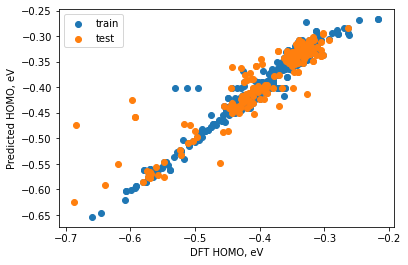

In [17]:
train.loc[:, 'predicted'] = model.predict_structures(train.defect_representation)
test.loc[:, 'predicted'] = model.predict_structures(test.defect_representation)
fig, ax = plt.subplots()
ax.scatter(train.homo, train.predicted, label="train")
ax.scatter(test.homo, test.predicted, label="test")
ax.set_xlabel("DFT HOMO, eV")
ax.set_ylabel("Predicted HOMO, eV")
ax.legend();